# STAT538A Final Project -- Report

**Investigating factors that influence the income of the citizens in US**

## Introduction



### Background

Identifying the factors that influence people's income is crucial for a fair society. The "Adult Data Set"[5] is such a dataset that records people's income and related variables in the US. It was collected by Barry Becker from the 1994 Census database. It allows us to predict whether income exceeds \$50K/year based on adult census data. With this dataset, we explore how the recorded variables influence people's income.

### Related Works

The UCI adult data was first cited by [1]. This work mainly focuses on the machine learning methodologies, it compares the prediction accuracy of several basic machine learning models. The prediction accuracy of the adult dataset reported in [1] is around 85%. [2] is a more recent work that also focuses on the prediction task. It proposes a gradient boosting approach which brings the accuracy to 88%. The dataset is also very popular in the machine learning fairness literature. [3] compares it's proposed model and some baseline methods in terms of prediction accuracy and discrimination scores. [4] extends this dataset into a more suitable dataset for fair machine learning. 


###  Our reseach objectives

In this project, by utilizing the learned generalized linear models (GLM), we want to mainly focus on the following two tasks:
* Build a GLM prediction model which will perform well in the dataset;
* Identify some key variables (or variable combinations) which have a large influence on one's income.

## Methods and Results

In this section, we will first introduce pre-processing methods for the dataset, followed by some key results from exploratory data analysis (EDA). Afterwards, we will present our logistic regression model along with its results.


#### Data Description

There are 15 variables in the dataset, the response variable is a binary variable that indicates whether one's annual income exceeds 50,000 or not. Other variables include demographical information (gender, race, age, education, marital status, relationship, native country), job type (occupation, work class, working hours per week), and capital information (capital gain, capital loss). There is another variable called 'fnlwgt', which indicates how many people this sample represents in the US.

There were 30162 complete observations amidst total 32561 observations. Missing data only exists in the variables `occupation`, and `native_country`. Since all of the missing variables are categorical, we converted the NA's to "Unknown" and treated the missing data simply as another category.

Although income is a continuous variable by nature, it is better to dichotomize income into two levels because our analysis is specifically interested in whether an adult's income is above or below 50K per year. By treating income as a binary variable, we also avoid extremely high outlier values.

#### Data Preprocessing

Some categorical variables in our dataset have an excessive number of levels. This makes it difficult for model interpretability because we may find some categorical levels to be significantly related to income and other levels to not be significantly related. We are not interested in whether or not each categorical level is related to income, but rather interested in whether or not the categorical variable as a whole is related to income.

Thus, we transformed the `native_country` variable into two continuous variables `gdp_per_capita` and `income_per_capita`. GDP and income data were extracted from the world bank website [6,7]. We used GDP and income data from 1994, which was the same year that adult data were collected. We matched country names from the adult training data with country names in the GDP and income data using string manipulation. For countries that had missing values for GDP or income, we simply imputed the mean GDP or mean income into those cells.

We also transformed the `workclass` and `occupation` variables into one categorical variable `job_class` with four categorical levels. To do this, we transformed the binary response variable `income` into 0's and 1's with 0's representing <= 50K income and 1's representing > 50K income. For each unique combination of `workclass` and `occupation`, we computed the mean income, and then divided the combinations into four groups based on their mean income with i1 representing the lowest average income group and i4 representing the highest average income group. Doing this reduces the number of categorical levels to be fed into the model, which allows for better model interpretability.

In [58]:
## LOAD DATA
rm(list = ls())
suppressMessages(library(GGally))
suppressMessages(library(tidyverse))
suppressMessages(library(glmnet))
library(gtsummary)
suppressMessages(library(psych))
library(broom)
suppressMessages(library(pROC))
suppressMessages(library(gridExtra))
library(knitr)
suppressMessages(library(Xmisc))
suppressMessages(library(caret))
suppressMessages(library(tm))
suppressMessages(library(SnowballC))
suppressMessages(library(wordcloud))
suppressMessages(library(RColorBrewer))
name_list = c('age',
             'workclass',
             'fnlwgt',
             'education',
             'education_num',
             'marital_status',
             'occupation',
             'relationship',
             'race',
             'gender',
             'capital_gain',
             'capital_loss',
             'hours_per_week',
             'native_country',
             'income')

adult_data = read.csv('data/adult.data', header = F)
adult_test = read.csv('data/adult.test',skip = 1, header = F)

names(adult_data) = name_list
names(adult_test) = name_list


adult_data[is.na(adult_data)] <- "Unknown"
adult_test[is.na(adult_test)]<- "Unknown"



adult_data$marital_status[adult_data$marital_status %in% c(' Married-civ-spouse',
                                                           ' Married-spouse-absent', 
                                                           ' Married-AF-spouse') ] = 'Married'

adult_test$marital_status[adult_test$marital_status %in% c(' Married-civ-spouse',
                                                           ' Married-spouse-absent', 
                                                           ' Married-AF-spouse') ] = 'Married'
adult_data = adult_data %>% 
    mutate(marital_status = factor(marital_status, levels = c('Married', ' Never-married', 
                                   ' Divorced', ' Separated', ' Widowed')))
adult_test = adult_test %>% 
    mutate(marital_status = factor(marital_status, levels = c('Married', ' Never-married', 
                                   ' Divorced', ' Separated', ' Widowed')))
adult_data = adult_data %>% 
    mutate(race = factor(race, levels =c(' White', ' Black', ' Asian-Pac-Islander',
                                      ' Amer-Indian-Eskimo', ' Other')))
adult_test = adult_test %>% 
    mutate(race = factor(race, levels =c(' White', ' Black', ' Asian-Pac-Islander',
                                      ' Amer-Indian-Eskimo', ' Other')))

# pre-process income column
adult_data = adult_data %>% mutate(income = replace(income, income == ' <=50K', 0),
              income = replace(income, income == ' >50K', 1))%>%
            mutate(income = as.integer(income))
adult_test =  adult_test %>% mutate(income = replace(income, income == ' <=50K.', 0),
          income = replace(income, income == ' >50K.', 1)) %>%
       mutate(income = as.integer(income))

# handle job type
tmp = adult_data %>% 
    group_by(workclass, occupation)%>%
    summarise(mean = mean(income),
             sd = sqrt(mean(income)*(1-mean(income))/n()))%>%ungroup()
tmp$class = paste(tmp$workclass, tmp$occupation, sep = '-')
threshold = quantile(tmp$mean, c(0.25,0.5,0.75))
job_class = c()
for(i in 1+rowSums(data.frame(a = tmp$mean > threshold[1],
           b = tmp$mean > threshold[2],
          c = tmp$mean > threshold[3])))
    job_class = c(job_class, c('i1', 'i2', 'i3', 'i4')[i])
tmp$job_class = job_class



join_data = tmp %>% select(class,job_class)
adult_data$class = paste(adult_data$workclass, adult_data$occupation, sep = '-')
adult_test$class = paste(adult_test$workclass, adult_test$occupation, sep = '-')
adult_data = left_join(adult_data,join_data,by ='class' ) %>% select(-class)
adult_test = left_join(adult_test,join_data,by ='class' ) %>% select(-class)


adult_test = adult_test %>% drop_na()

## PREPROCESS TRAINING DATA (GDP_DATA)


# read GDP and income data for native countrys
gdp_data = read.csv('data/gdp_per_capita.csv', header = F)
income_data = read.csv('data/income_per_capita.csv', header = F)

gdp_data <- gdp_data[c(-1,-2),]
colnames(gdp_data) <- gdp_data[1,]
gdp_data <- gdp_data[-1,]
rownames(gdp_data) <- 1:nrow(gdp_data)
colnames(gdp_data)[1] <- "native_country"

gdp_data <- gdp_data %>% 
  select(native_country, "1994")

# clean native_country names in adult_data
adult_data$native_country <- str_trim(adult_data$native_country, side = c("left"))
adult_data$native_country <- gsub("-", " ", adult_data$native_country)

lj <- left_join(adult_data, gdp_data, by = "native_country")

# find the native countries in adult_data that aren't in gdp_data
lj_unique <- lj[is.na(lj$"1994"),]$native_country %>% unique()

# replace country names in adult_data that are in gdp_data
adult_data$native_country <- gsub("South", "South Africa", adult_data$native_country)
adult_data$native_country <- gsub("England", "United Kingdom", adult_data$native_country)
adult_data$native_country <- gsub("Iran", "Iran, Islamic Rep.", adult_data$native_country)
adult_data$native_country <- gsub("Columbia", "Colombia", adult_data$native_country)
adult_data$native_country <- gsub("Laos", "South Asia", adult_data$native_country)
adult_data$native_country <- gsub("Taiwan", "China", adult_data$native_country)
# adult_data <- adult_data[!adult_data$native_country == "Yugoslavia",]
# adult_data <- adult_data[!adult_data$native_country == "Outlying US(Guam USVI etc)",]
adult_data$native_country <- gsub("Scotland", "United Kingdom", adult_data$native_country)
adult_data$native_country <- gsub("Trinadad&Tobago", "Caribbean small states", adult_data$native_country)
adult_data$native_country <- gsub("Hong", "Hong Kong SAR, China", adult_data$native_country)
adult_data$native_country <- gsub("Holand Netherlands", "Netherlands", adult_data$native_country)

# left join again
lj <- left_join(adult_data, gdp_data, by = "native_country")

# rename column
colnames(lj)[colnames(lj) == "1994"] <- "gdp_per_capita"

## PREPROCESS TRAINING DATA (INCOME_DATA)

# income data wrangling
income_data <- income_data[c(-1,-2),]
colnames(income_data) <- income_data[1,]
income_data <- income_data[-1,]
rownames(income_data) <- 1:nrow(income_data)
colnames(income_data)[1] <- "native_country"

income_data <- income_data %>% 
  select(native_country, "1994")

lj_2 <- left_join(lj, income_data, by = "native_country")

# find the native countries in adult_data that aren't in income_data
lj_unique_2 <- lj_2[is.na(lj_2$"1994"),]$native_country %>% unique()

# rename income
colnames(lj_2)[colnames(lj_2) == "1994"] <- "income_per_capita"

## PREPROCESS TESTING DATA (GDP_DATA)

adult_test <- adult_test[-1,]
row.names(adult_test) <- 1:nrow(adult_test)

# clean native_country names in adult_test
adult_test$native_country <- str_trim(adult_test$native_country, side = c("left"))
adult_test$native_country <- gsub("-", " ", adult_test$native_country)

lj_test <- left_join(adult_test, gdp_data, by = "native_country")
# find the native countries in adult_test that aren't in gdp_data
lj_unique_test <- lj_test[is.na(lj_test$"1994"),]$native_country %>% unique()

# replace country names in adult_test that are in gdp_data
adult_test$native_country <- gsub("South", "South Africa", adult_test$native_country)
adult_test$native_country <- gsub("Columbia", "Colombia", adult_test$native_country)
adult_test$native_country <- gsub("Laos", "South Asia", adult_test$native_country)
adult_test$native_country <- gsub("England", "United Kingdom", adult_test$native_country)
adult_test$native_country <- gsub("Taiwan", "China", adult_test$native_country)
adult_test$native_country <- gsub("Iran", "Iran, Islamic Rep.", adult_test$native_country)
adult_test$native_country <- gsub("Scotland", "United Kingdom", adult_test$native_country)
adult_test <- adult_test[!adult_test$native_country == "Yugoslavia",]
adult_test$native_country <- gsub("Hong", "Hong Kong SAR, China", adult_test$native_country)
adult_test$native_country <- gsub("Trinadad&Tobago", "Caribbean small states", adult_test$native_country)
adult_test <- adult_test[!adult_test$native_country == "Outlying US(Guam USVI etc)",]

# left join again
lj_test <- left_join(adult_test, gdp_data, by = "native_country")

# rename column
colnames(lj_test)[colnames(lj_test) == "1994"] <- "gdp_per_capita"

lj_2_test <- left_join(lj_test, income_data, by = "native_country")
# find the native countries in adult_data that aren't in income_data
lj_unique_2_test <- lj_2_test[is.na(lj_2_test$"1994"),]$native_country %>% unique()
# rename income
colnames(lj_2_test)[colnames(lj_2_test) == "1994"] <- "income_per_capita"
## FINAL RENAME
adult_data <- lj_2
adult_test <- lj_2_test

adult_data$gdp_per_capita[is.na(adult_data$gdp_per_capita)] = mean(gdp_data$`1994`, na.rm = T)
adult_test$gdp_per_capita[is.na(adult_test$gdp_per_capita)] = mean(gdp_data$`1994`, na.rm = T)

adult_data$income_per_capita[is.na(adult_data$income_per_capita)] = mean(income_data$`1994`, na.rm = T)
adult_test$income_per_capita[is.na(adult_test$income_per_capita)] = mean(income_data$`1994`, na.rm = T)

train_data = adult_data %>% select(-education, -relationship, - occupation, -workclass,-native_country)
test_data = adult_test %>% select(-education, -relationship, - occupation, -workclass,-native_country)

`summarise()` has grouped output by 'workclass'. You can override using the `.groups` argument.



### Exploratory Data Analysis (EDA)

In this subsection, we will conduct exploratory data analysis to examine basic properties of the data.

First, let's look at the sample size and missing data. The summary table shows the total number of observations, the proportion of observations with greater than 50K income, and shows that we did impute the missing values.

In [60]:
# preprocess back
adult_data = adult_data %>% mutate(income = replace(income, income == 0, ' <=50K'),
              income = replace(income, income == 1, ' >50K'))

adult_data[adult_data == "Unknown"] <- NA
rows_missing <- sum(!complete.cases(adult_data))
rows_complete <- sum(complete.cases(adult_data))
adult_data[is.na(adult_data)] <- "Unknown"

EDA_df <- data.frame(
  Statistic = c("Number of Observations (Rows)",
                "Number of Observations with Missing Data (Rows)", 
                "Number of Complete Observations (Rows)",
                "Proportion of Income >50K", 
                "Proportion of Income <=50K"),
  Value = c(nrow(adult_data), 
            rows_missing, 
            rows_complete, 
            sum(adult_data$income == " >50K")/length(adult_data$income),
            sum(adult_data$income == " <=50K")/length(adult_data$income))
)

EDA_df$Value <- round(EDA_df$Value, 3)
kable(EDA_df, caption = "Descriptive Summary Statistics")



Table: Descriptive Summary Statistics

|Statistic                                       |     Value|
|:-----------------------------------------------|---------:|
|Number of Observations (Rows)                   | 32561.000|
|Number of Observations with Missing Data (Rows) |     0.000|
|Number of Complete Observations (Rows)          | 32561.000|
|Proportion of Income >50K                       |     0.241|
|Proportion of Income <=50K                      |     0.759|

Next, let's look at some plots to investigate the one-to-one relationship between the response variable and other variables.

`summarise()` has grouped output by 'marital_status'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'occupation'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'relationship'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'race'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'gender'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'native_country'. You can override using the `.groups` argument.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



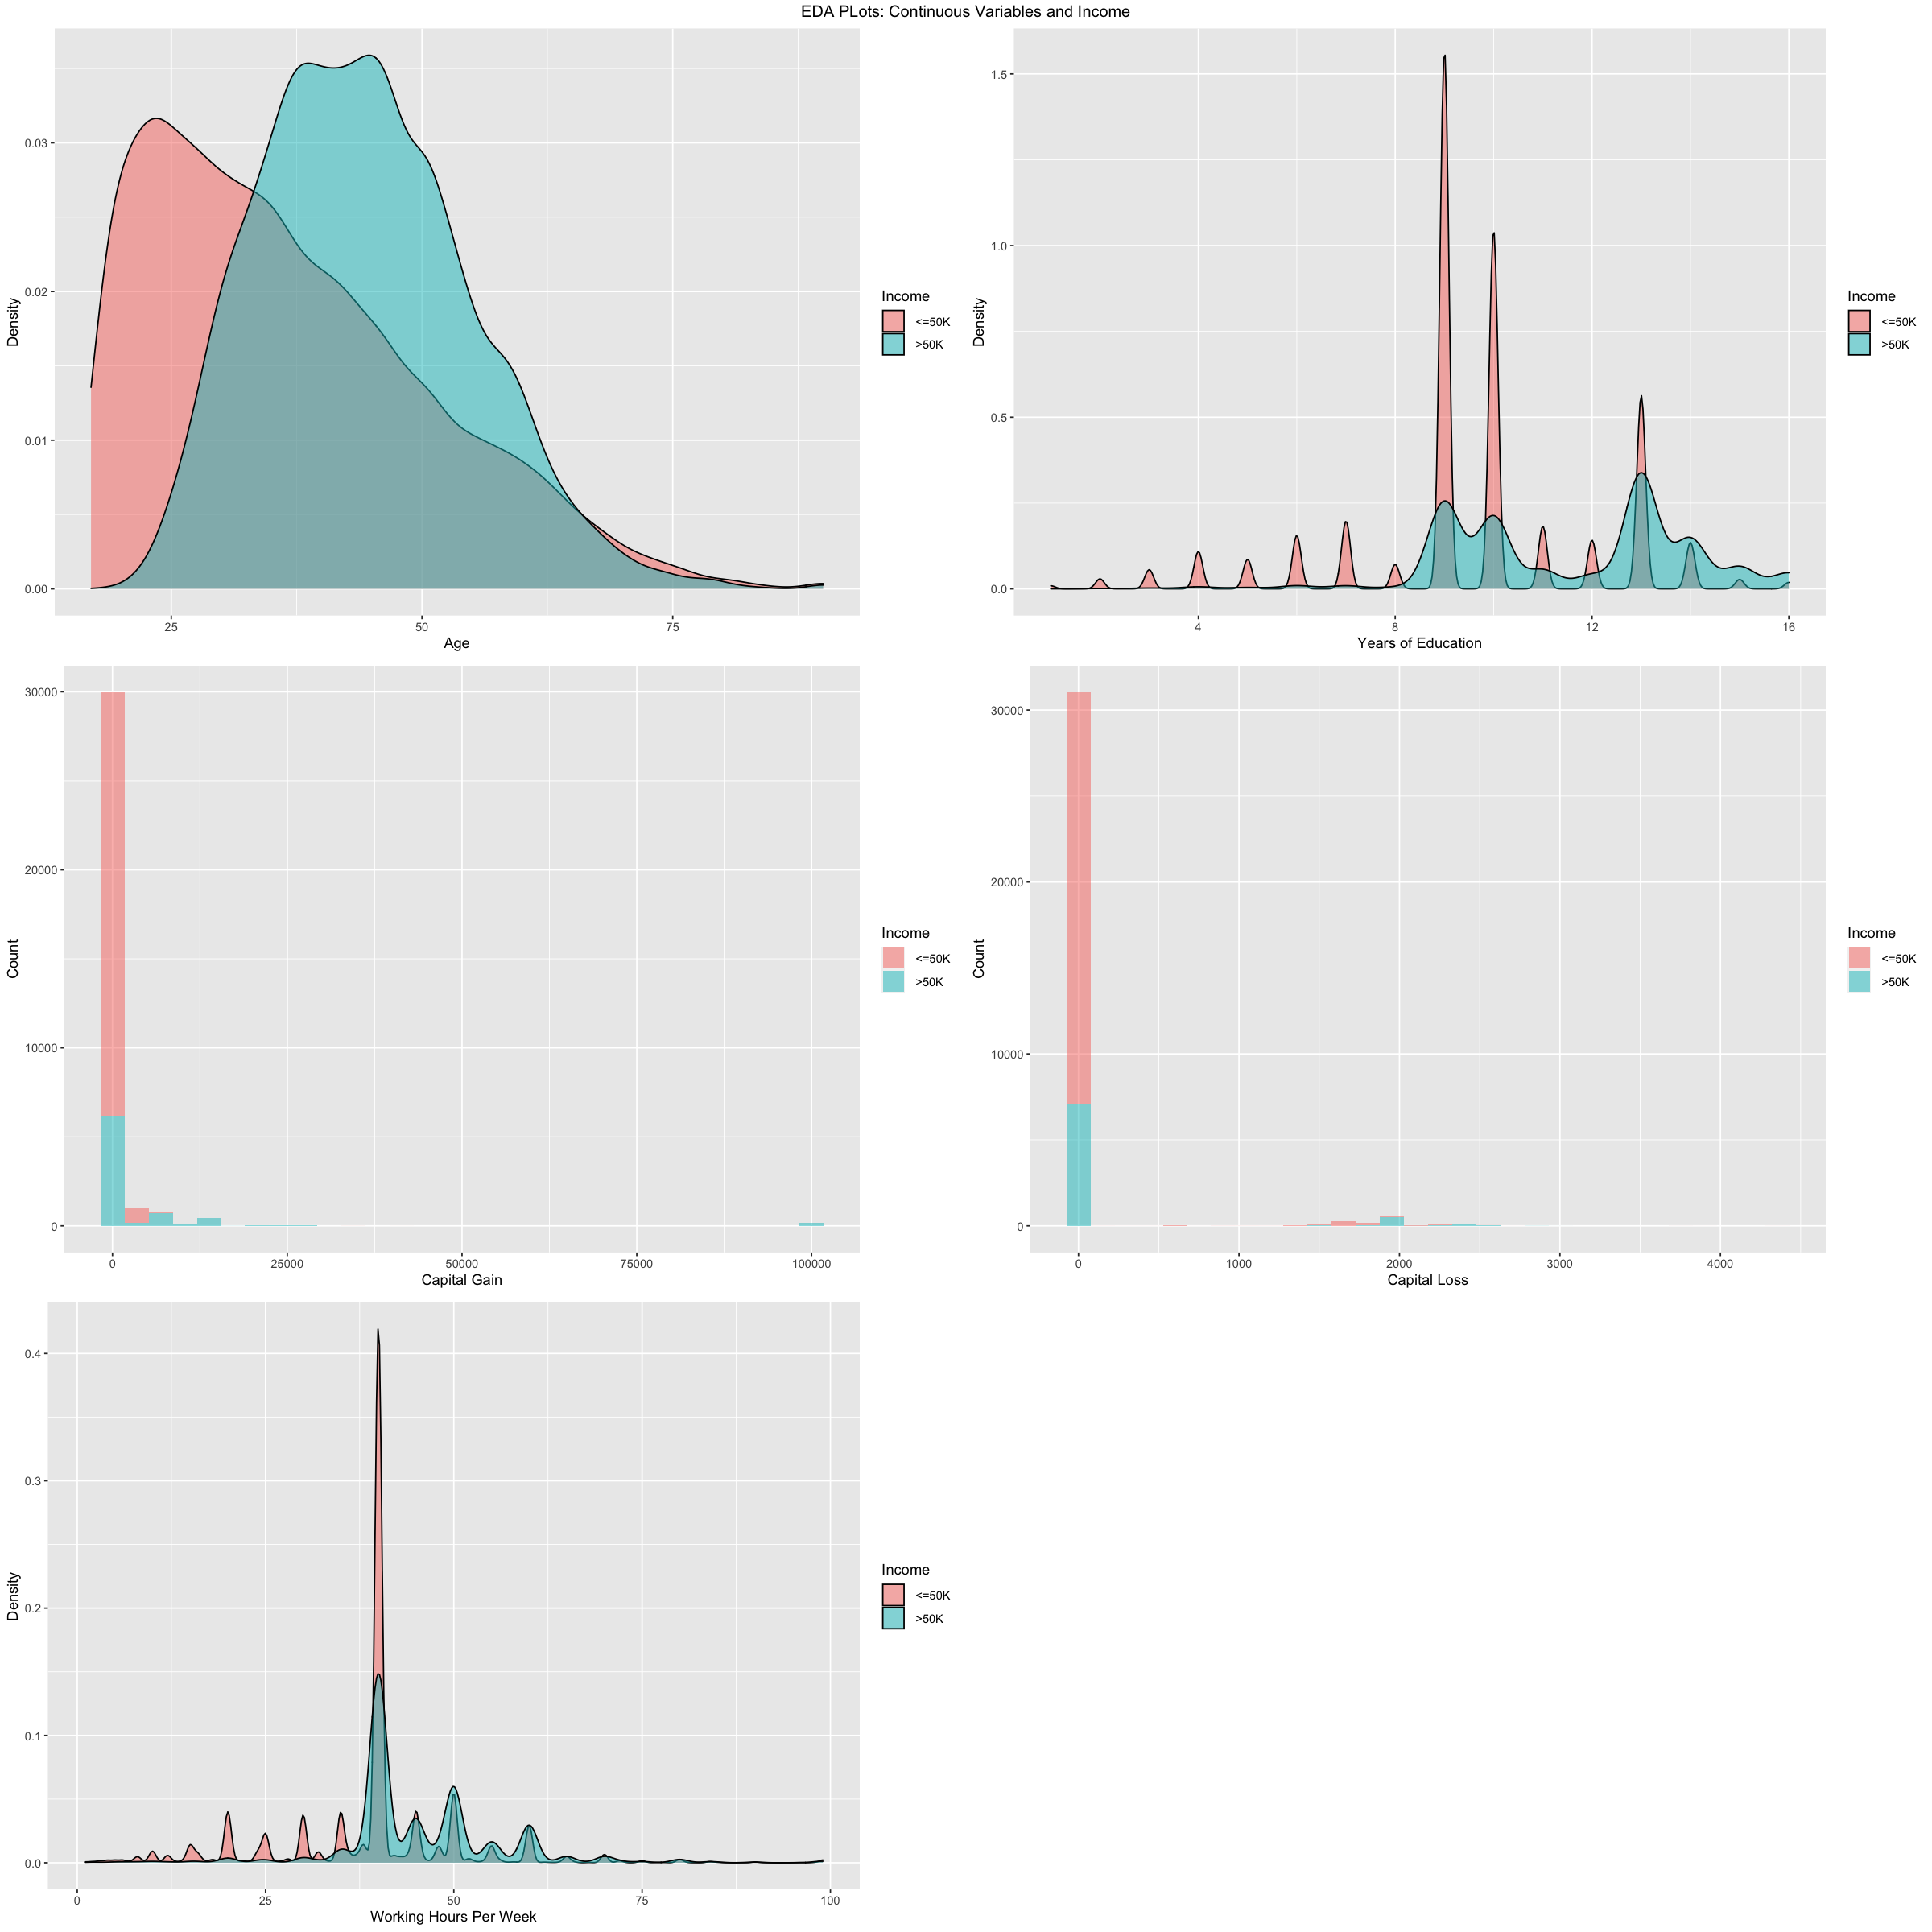

In [61]:
# age EDA (continuous)
a <- ggplot(data = adult_data, aes(x = age, fill = income)) + 
  geom_density(alpha = 0.5) +
  labs(x = "Age", y = "Density", fill = "Income")
# education_num EDA (continuous)
above_50_edunum <- adult_data %>% 
  filter(income == " >50K") %>% 
  select(education_num)

below_50_edunum <- adult_data %>% 
  filter(income == " <=50K") %>% 
  select(education_num)

# test_edunum <- t.test(above_50_edunum, below_50_edunum)
# test_edunum_p <- test_edunum$p.value

# dat_edunum <- adult_data %>% 
#   group_by(education_num, income) %>% 
#   summarise(count = n()) %>% 
#   mutate(perc = count/sum(count))

# PLOT A (treat it as categorical)
# ggplot(data = dat_edunum, aes(x = education_num, y = perc*100, fill = income)) +
#   geom_histogram(stat = "identity") +
#   labs(x = "Years of Education", y = "Percent", fill = "Income") +
#   geom_text(aes(3, 95,label = paste0("t-test: p-value = ", round(test_edunum_p, 3))))

# PLOT B (treat it as continuous)
b <- ggplot(data = adult_data, aes(x = education_num, fill = income)) + 
  geom_density(alpha = 0.5) +
  labs(x = "Years of Education", y = "Density", fill = "Income")
  # geom_text(aes(3, 1.5,label = paste0("t-test: p-value = ", round(test_edunum_p, 3))))



# grid.arrange(a, a, b, b, a, a, a, a, b, b, b, b, ncol = 3, nrow = 4)
# ?grid.arrange()


# marital status EDA (categorical)
dat_marital <- adult_data %>% 
  group_by(marital_status, income) %>% 
  summarise(count = n()) %>% 
  mutate(perc = count/sum(count))

# test_marital <- chisq.test(table(adult_data$marital_status, adult_data$income))
# test_marital_p <- test_marital$p.value

c <- ggplot(data = dat_marital, aes(x= factor(marital_status), y = perc*100, fill = factor(income))) +
  geom_bar(stat = "identity") + 
  labs(x = "Marital Status", y = "Percent", fill = "Income") +
  theme(axis.text.x = element_text(angle = 30, vjust = 0.95)) + 
  ggtitle("Marital Status and Income")
  # geom_text(aes(3, 95,label = paste0("chi-squared test: p-value = ", round(test_marital_p, 3))))

# occupation EDA (categorical)
dat_occupation <- adult_data %>% 
  group_by(occupation, income) %>% 
  summarise(count = n()) %>% 
  mutate(perc = count/sum(count))

# test_occupation <- chisq.test(table(adult_data$occupation, adult_data$income))
# test_occupation_p <- test_occupation$p.value

d <- ggplot(data = dat_occupation, aes(x= factor(occupation), y = perc*100, fill = factor(income))) +
  geom_bar(stat = "identity") + 
  labs(x = "Occupation", y = "Percent", fill = "Income") +
  theme(axis.text.x = element_text(angle = 30, vjust = 0.95)) + 
  ggtitle("Occupation and Income")
  # geom_text(aes(3, 95,label = paste0("chi-squared test: p-value = ", round(test_occupation_p, 3))))

# relationship EDA (categorical)
dat_relationship <- adult_data %>% 
  group_by(relationship, income) %>% 
  summarise(count = n()) %>% 
  mutate(perc = count/sum(count))

# test_relationship <- chisq.test(table(adult_data$relationship, adult_data$income))
# test_relationship_p <- test_relationship$p.value

e <- ggplot(data = dat_relationship, aes(x= factor(relationship), y = perc*100, fill = factor(income))) +
  geom_bar(stat = "identity") + 
  labs(x = "Relationship Status", y = "Percent", fill = "Income") +
  theme(axis.text.x = element_text(angle = 30)) + 
  ggtitle("Relationship Status and Income")
  # geom_text(aes(3, 95,label = paste0("chi-squared test: p-value = ", round(test_relationship_p, 3))))

# race EDA (categorical)
dat_race <- adult_data %>% 
  group_by(race, income) %>% 
  summarise(count = n()) %>% 
  mutate(perc = count/sum(count))

# test_race <- chisq.test(table(adult_data$race, adult_data$income))
# test_race_p <- test_race$p.value

f <- ggplot(data = dat_race, aes(x= factor(race), y = perc*100, fill = factor(income))) +
  geom_bar(stat = "identity") + 
  labs(x = "Race", y = "Percent", fill = "Income") +
  theme(axis.text.x = element_text(angle = 30, vjust = 0.95)) + 
  ggtitle("Race and Income")
  # geom_text(aes(3, 95,label = paste0("chi-squared test: p-value = ", round(test_race_p, 3))))


# gender EDA (categorical)
dat_gender <- adult_data %>% 
  group_by(gender, income) %>% 
  summarise(count = n()) %>% 
  mutate(perc = count/sum(count))

# test_gender <- chisq.test(table(adult_data$gender, adult_data$income))
# test_gender_p <- test_gender$p.value

g <- ggplot(data = dat_gender, aes(x= factor(gender), y = perc*100, fill = factor(income))) +
  geom_bar(stat = "identity") + 
  labs(x = "Gender", y = "Percent", fill = "Income") +
  theme(axis.text.x = element_text(angle = 30)) + 
  ggtitle("Gender and Income")
  # geom_text(aes(3, 95,label = paste0("chi-squared test: p-value = ", round(test_gender_p, 3))))


# capital gain EDA (continuous)
h <- ggplot(data = adult_data, aes(x = capital_gain, fill = income)) + 
  geom_histogram(alpha = 0.5) +
  labs(x = "Capital Gain", y = "Count", fill = "Income")


# capital loss EDA (continuous)
i <- ggplot(data = adult_data, aes(x = capital_loss, fill = income)) + 
  geom_histogram(alpha = 0.5) +
  labs(x = "Capital Loss", y = "Count", fill = "Income")


# hours per week EDA (continuous)
j <- ggplot(data = adult_data, aes(x = hours_per_week, fill = income)) + 
  geom_density(alpha = 0.5) +
  labs(x = "Working Hours Per Week", y = "Density", fill = "Income")


# native country EDA (categorical)
dat_native <- adult_data %>% 
  group_by(native_country, income) %>% 
  summarise(count = n()) %>% 
  mutate(perc = count/sum(count))

# test_native <- chisq.test(table(adult_data$native_country, adult_data$income))
# test_native_p <- test_native$p.value

k <- ggplot(data = dat_native, aes(x= factor(native_country), y = perc*100, fill = factor(income))) +
  geom_bar(stat = "identity") + 
  labs(x = "Native Country", y = "Percent", fill = "Income") +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.75)) +
  ggtitle("Native Country and Income")#+
  # geom_text(aes(10, 95,label = paste0("chi-squared test: p-value = ", round(test_native_p, 3))))

# preprocess label back
adult_data = adult_data %>% mutate(income = replace(income, income == ' <=50K', 0),
              income = replace(income, income == ' >50K', 1))%>%
            mutate(income = as.integer(income))

# run all EDA plots
# EDA for continuous variables
grid.arrange(a, b, h, i, j, ncol = 2, nrow = 3, top = "EDA PLots: Continuous Variables and Income")


Density plots and bar plots show the relationship between each continuous variable and income. For example, the age vs. income plot suggests that older people are more likely to have greater than 50K income per year. 

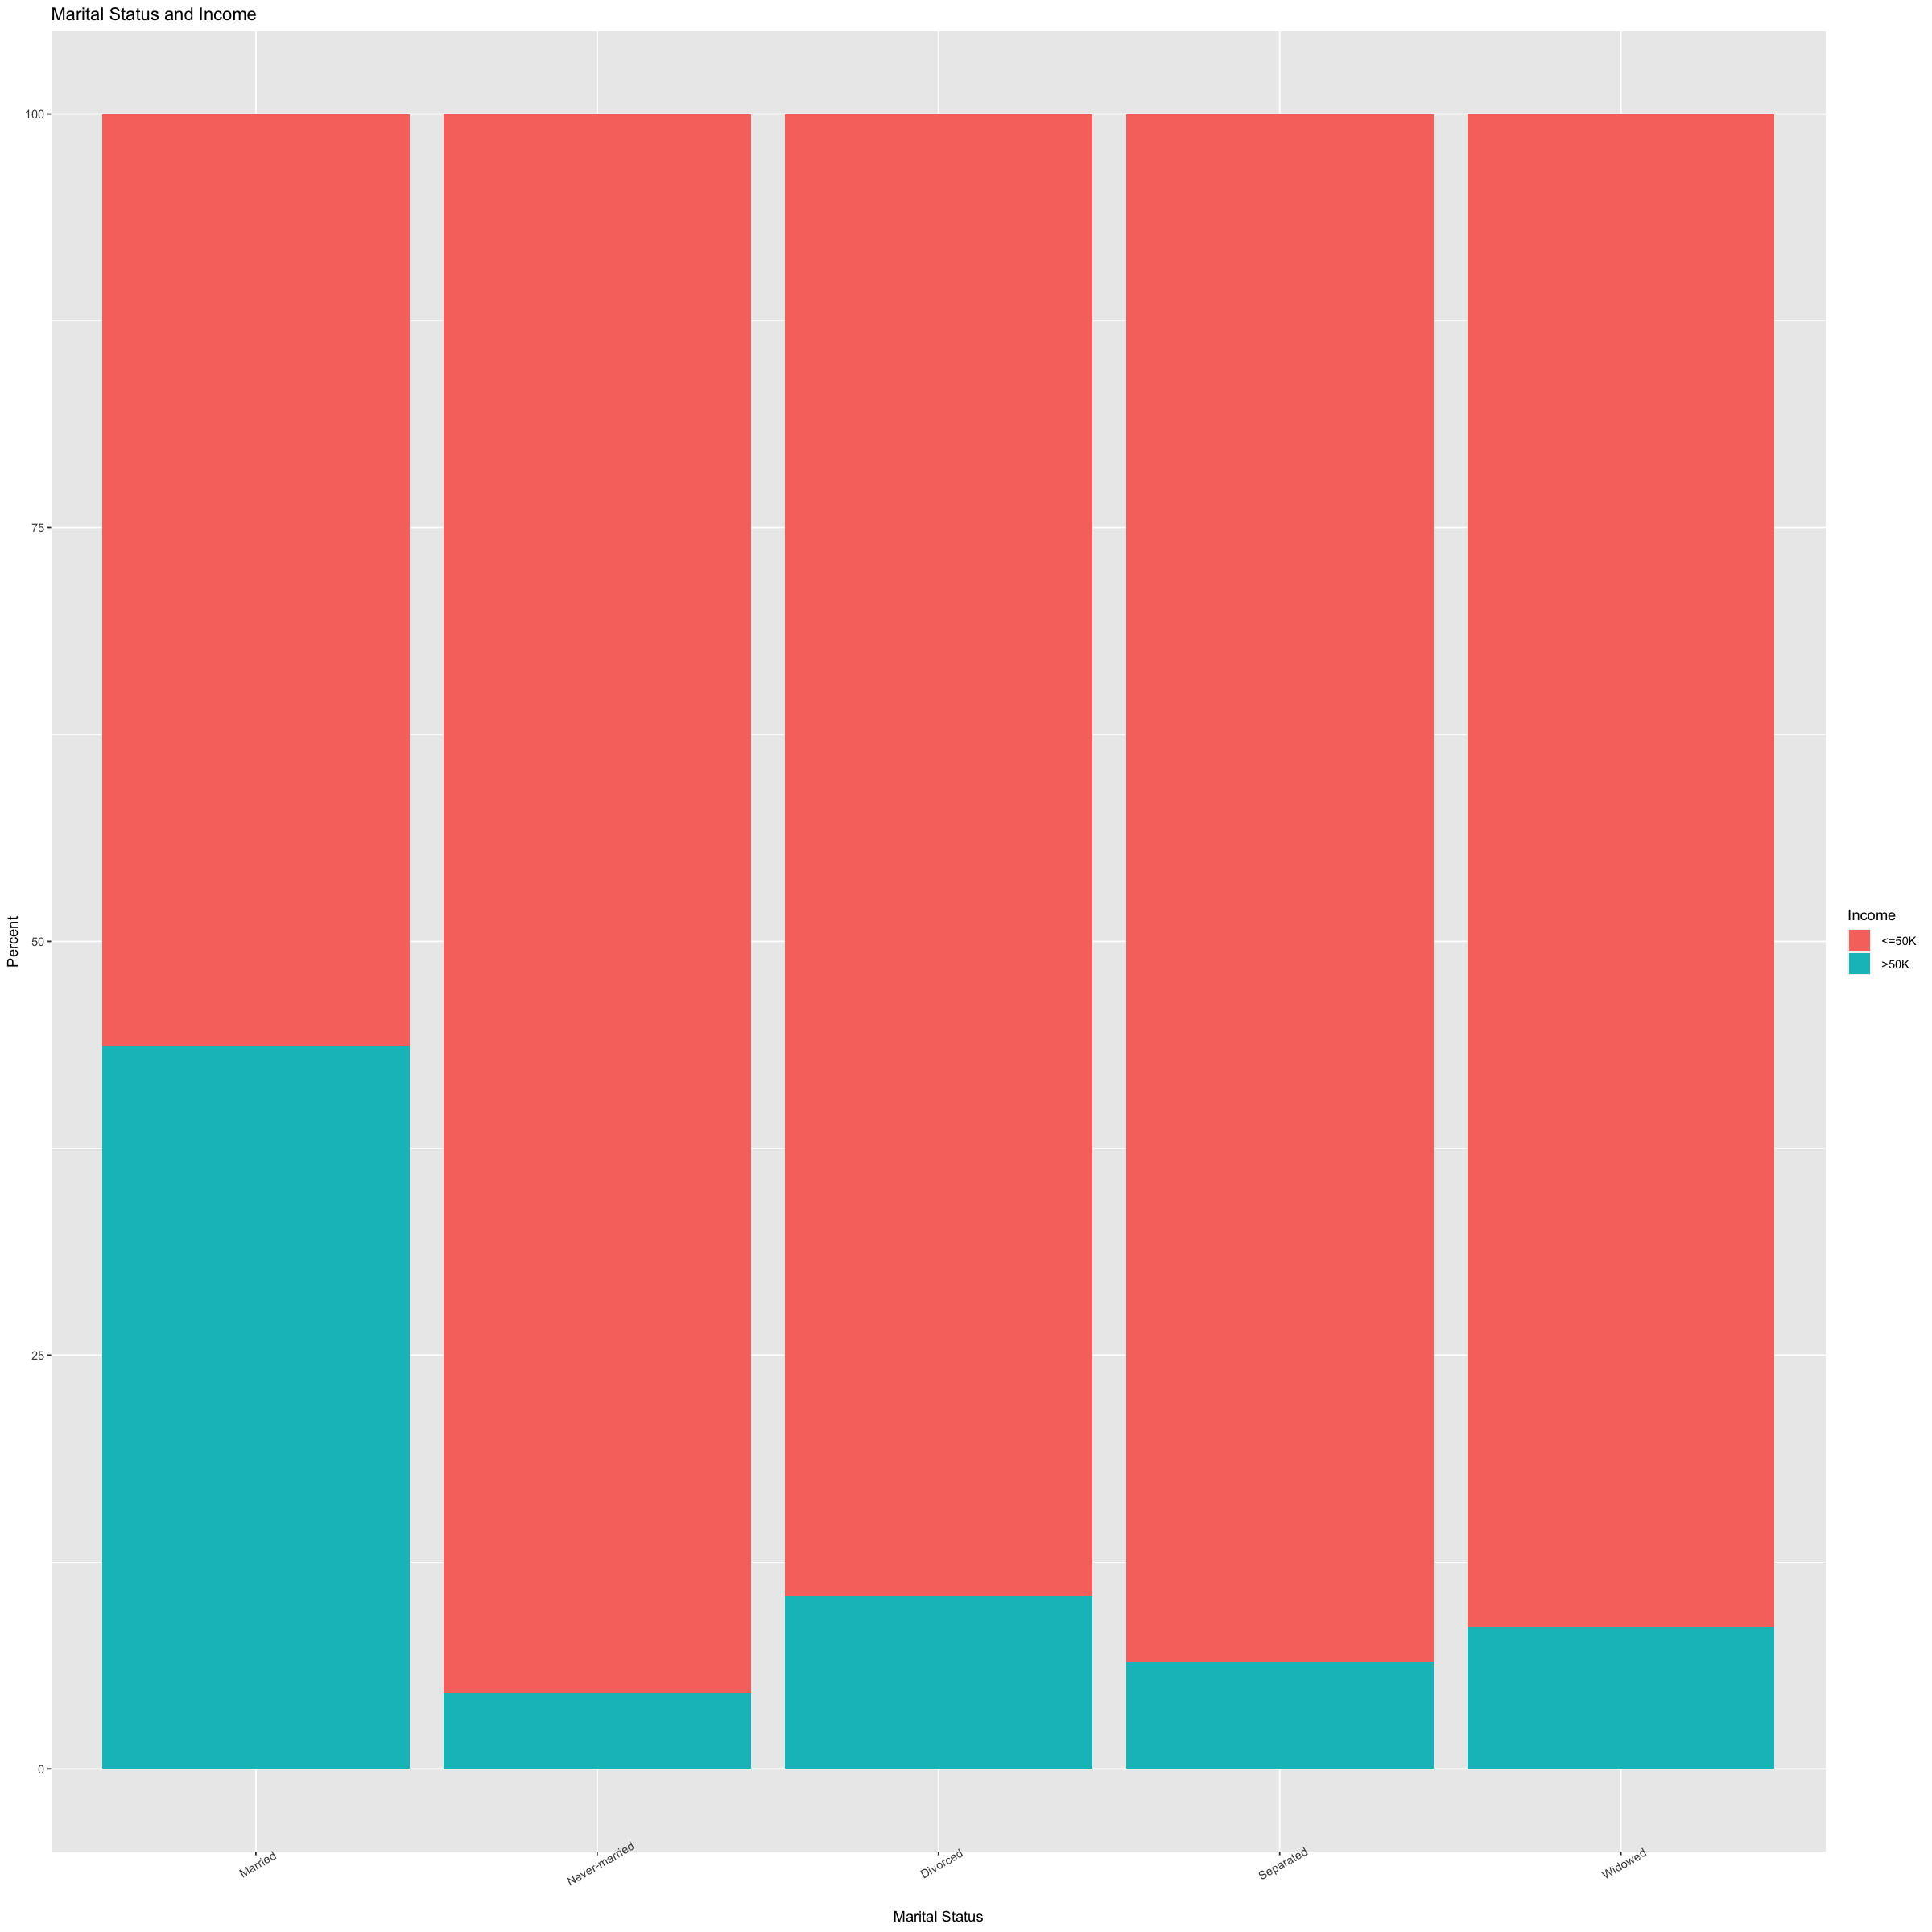

In [62]:
# EDA for categorical variables
c

Bar plot showing the relationship between marital status and income suggests that married people are more likely to have greater than 50K income.

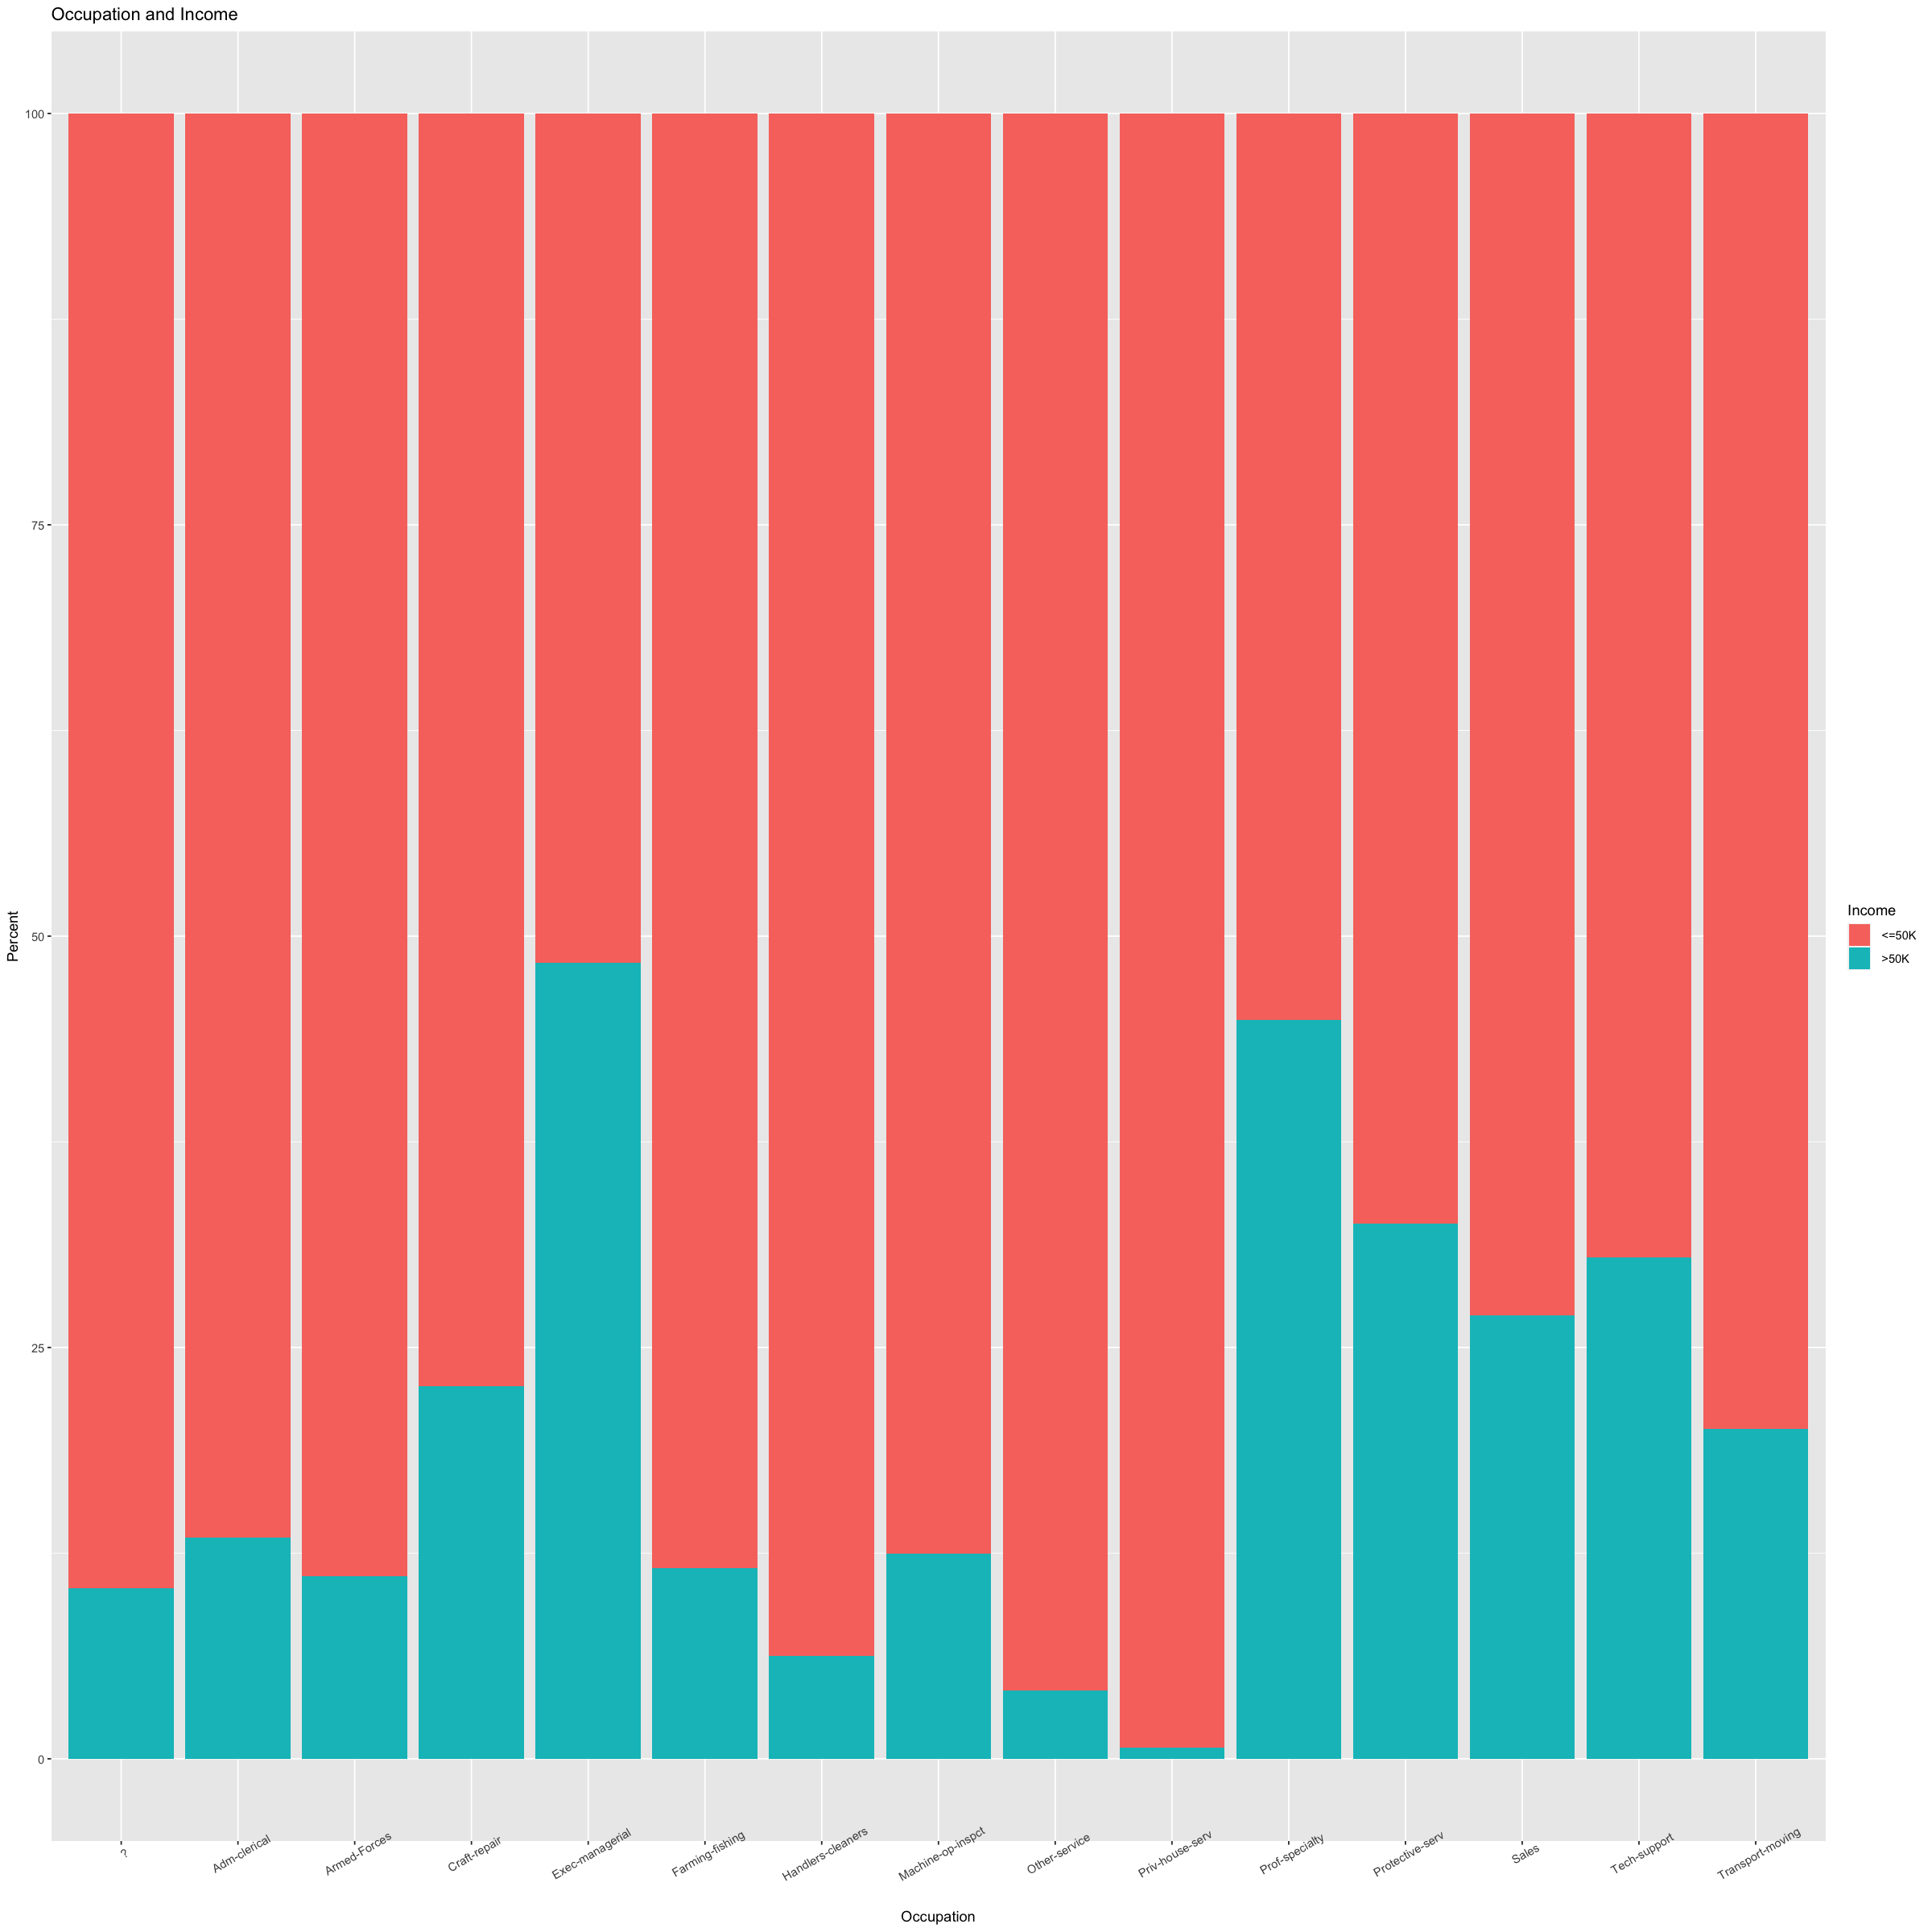

In [63]:
d

Bar plot showing the relationship between occupation and income suggests that certain occupations such as "Exec-Managerial", "Priv-house-serv", and "Tech-support" are more likely to have greater than 50K income.


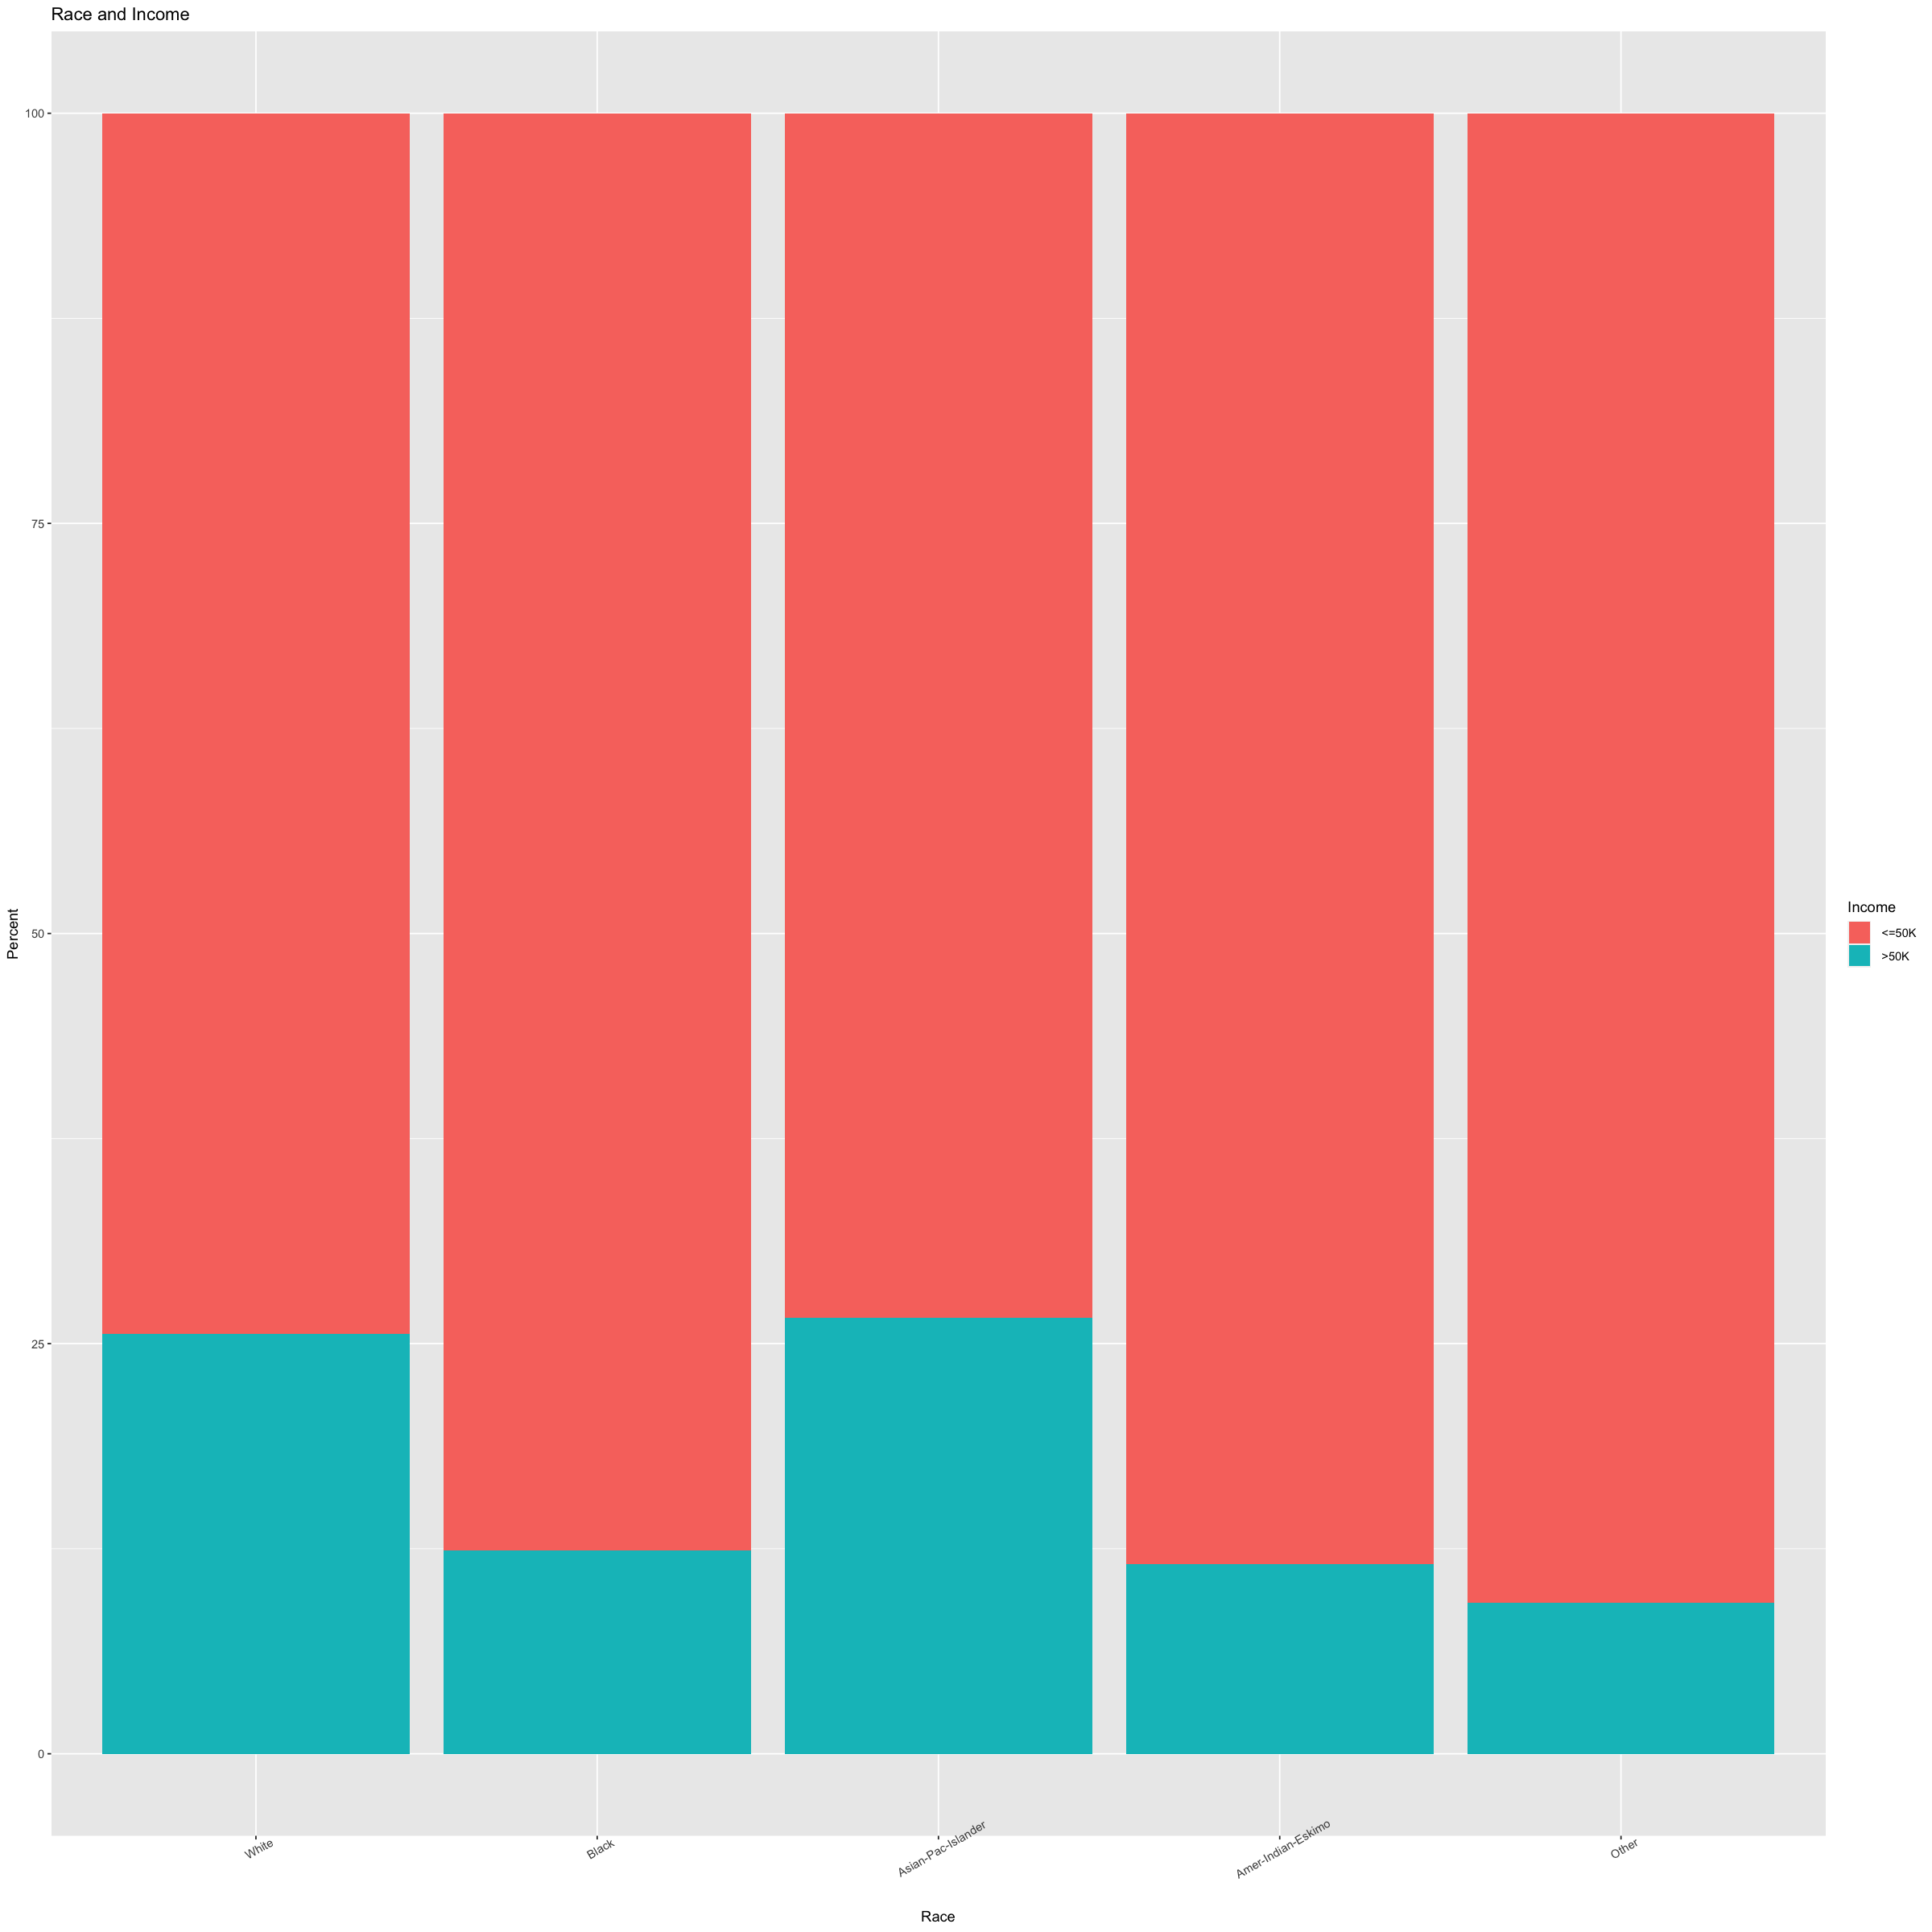

In [64]:
f


Bar plot showing the relationship between race and income suggests that "White" or "Asian-Pac-Islander" people are more likely to have greater than 50K income.

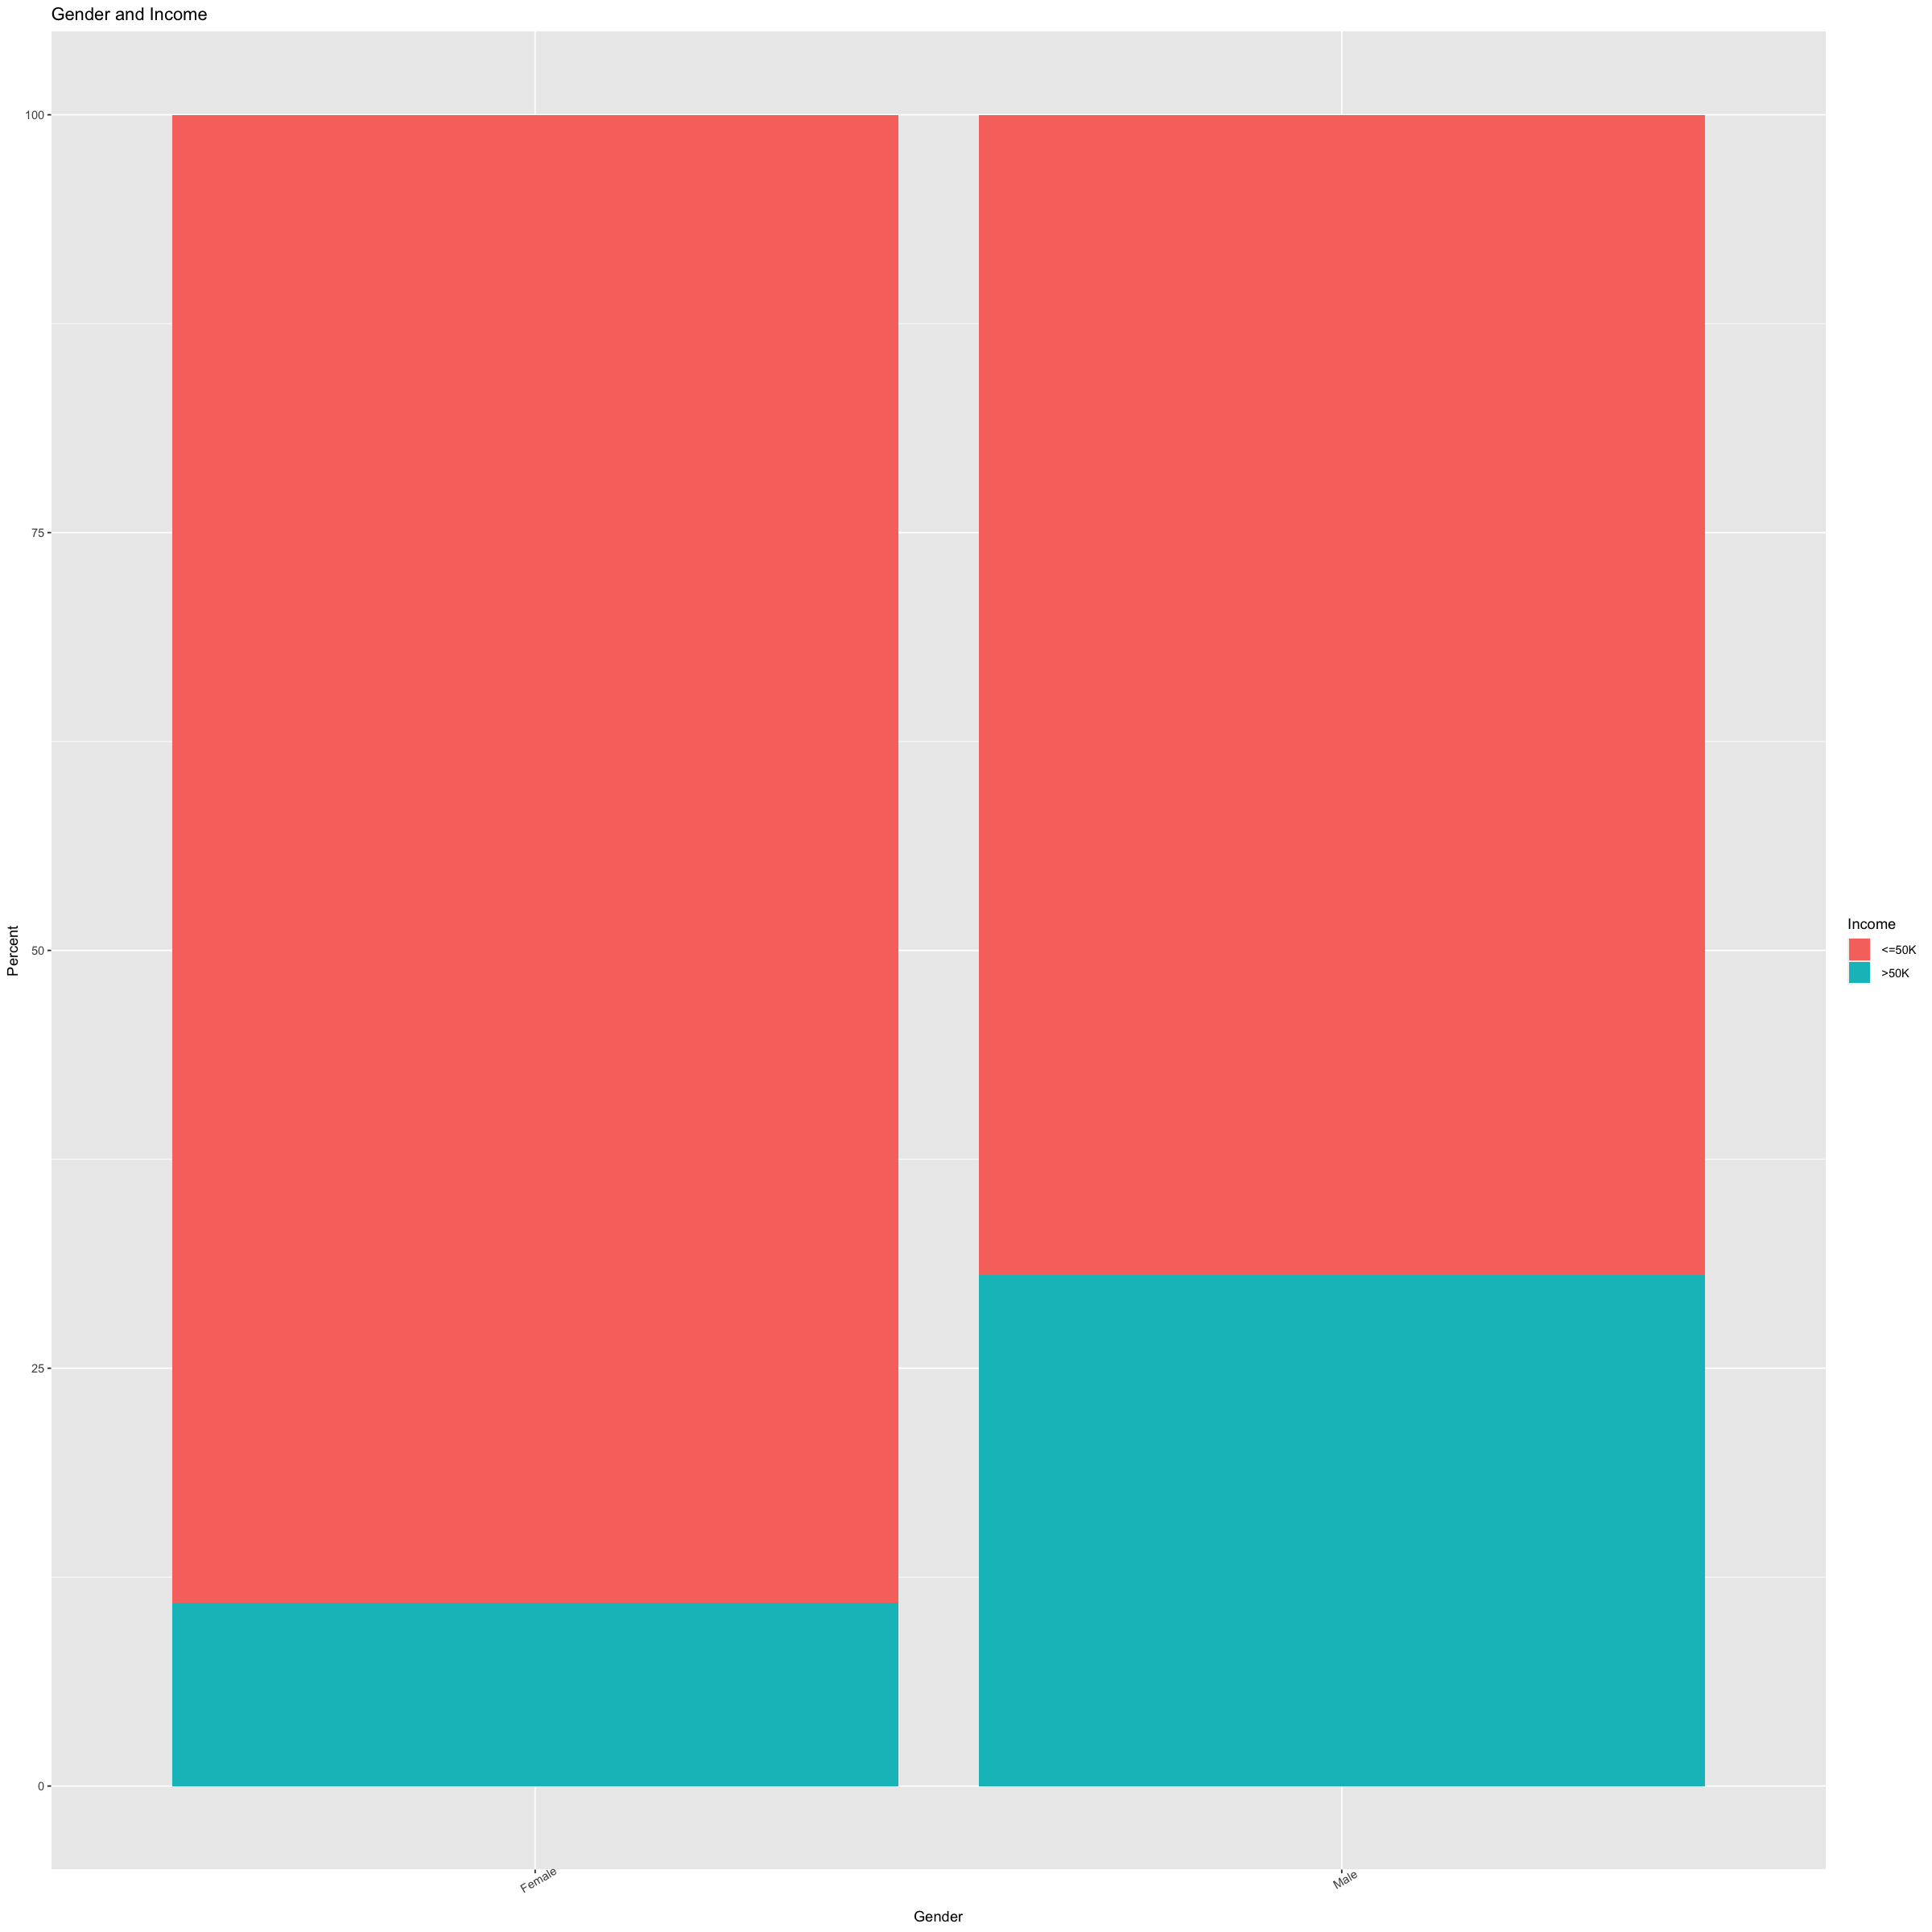

In [65]:
g

Bar plot showing the relationship between gender and income suggests that males are more likely to have greater than 50K income.


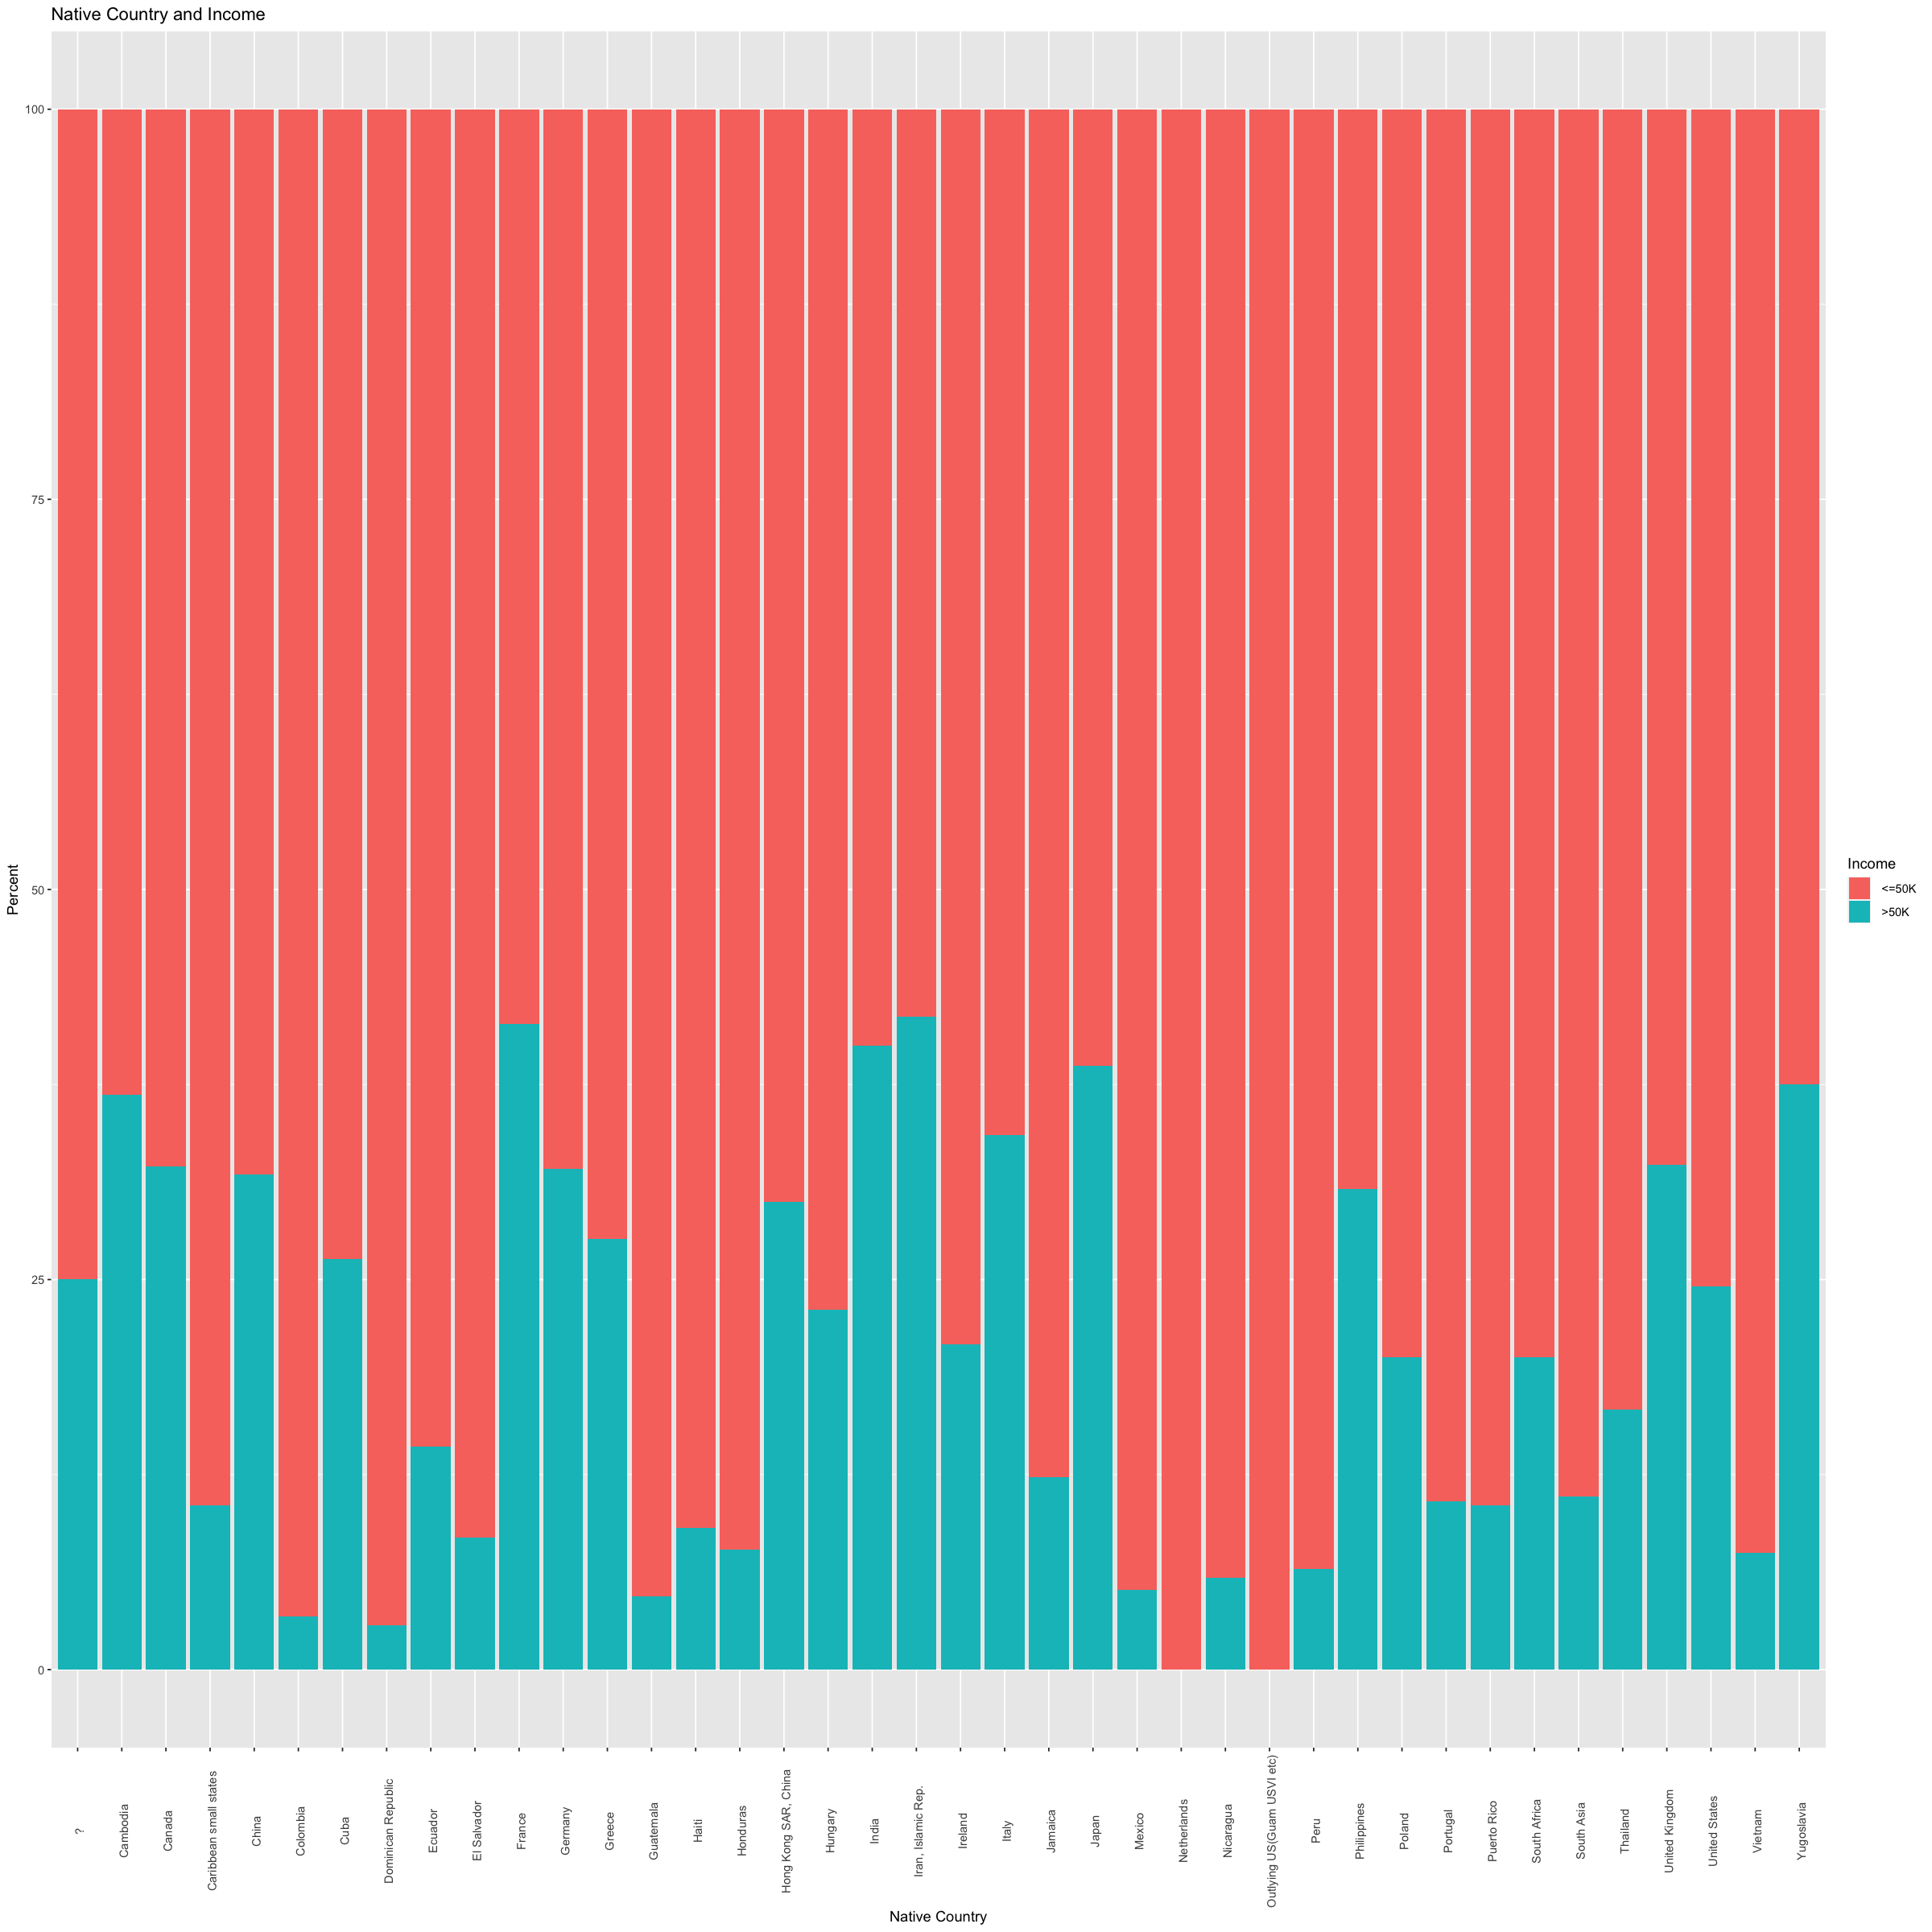

In [66]:
k

Bar plot showing the relationship between native country and income shows that some countries are more likely to have greater than 50K income while other countries are more likely to have less than or equal to 50K income.


geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?



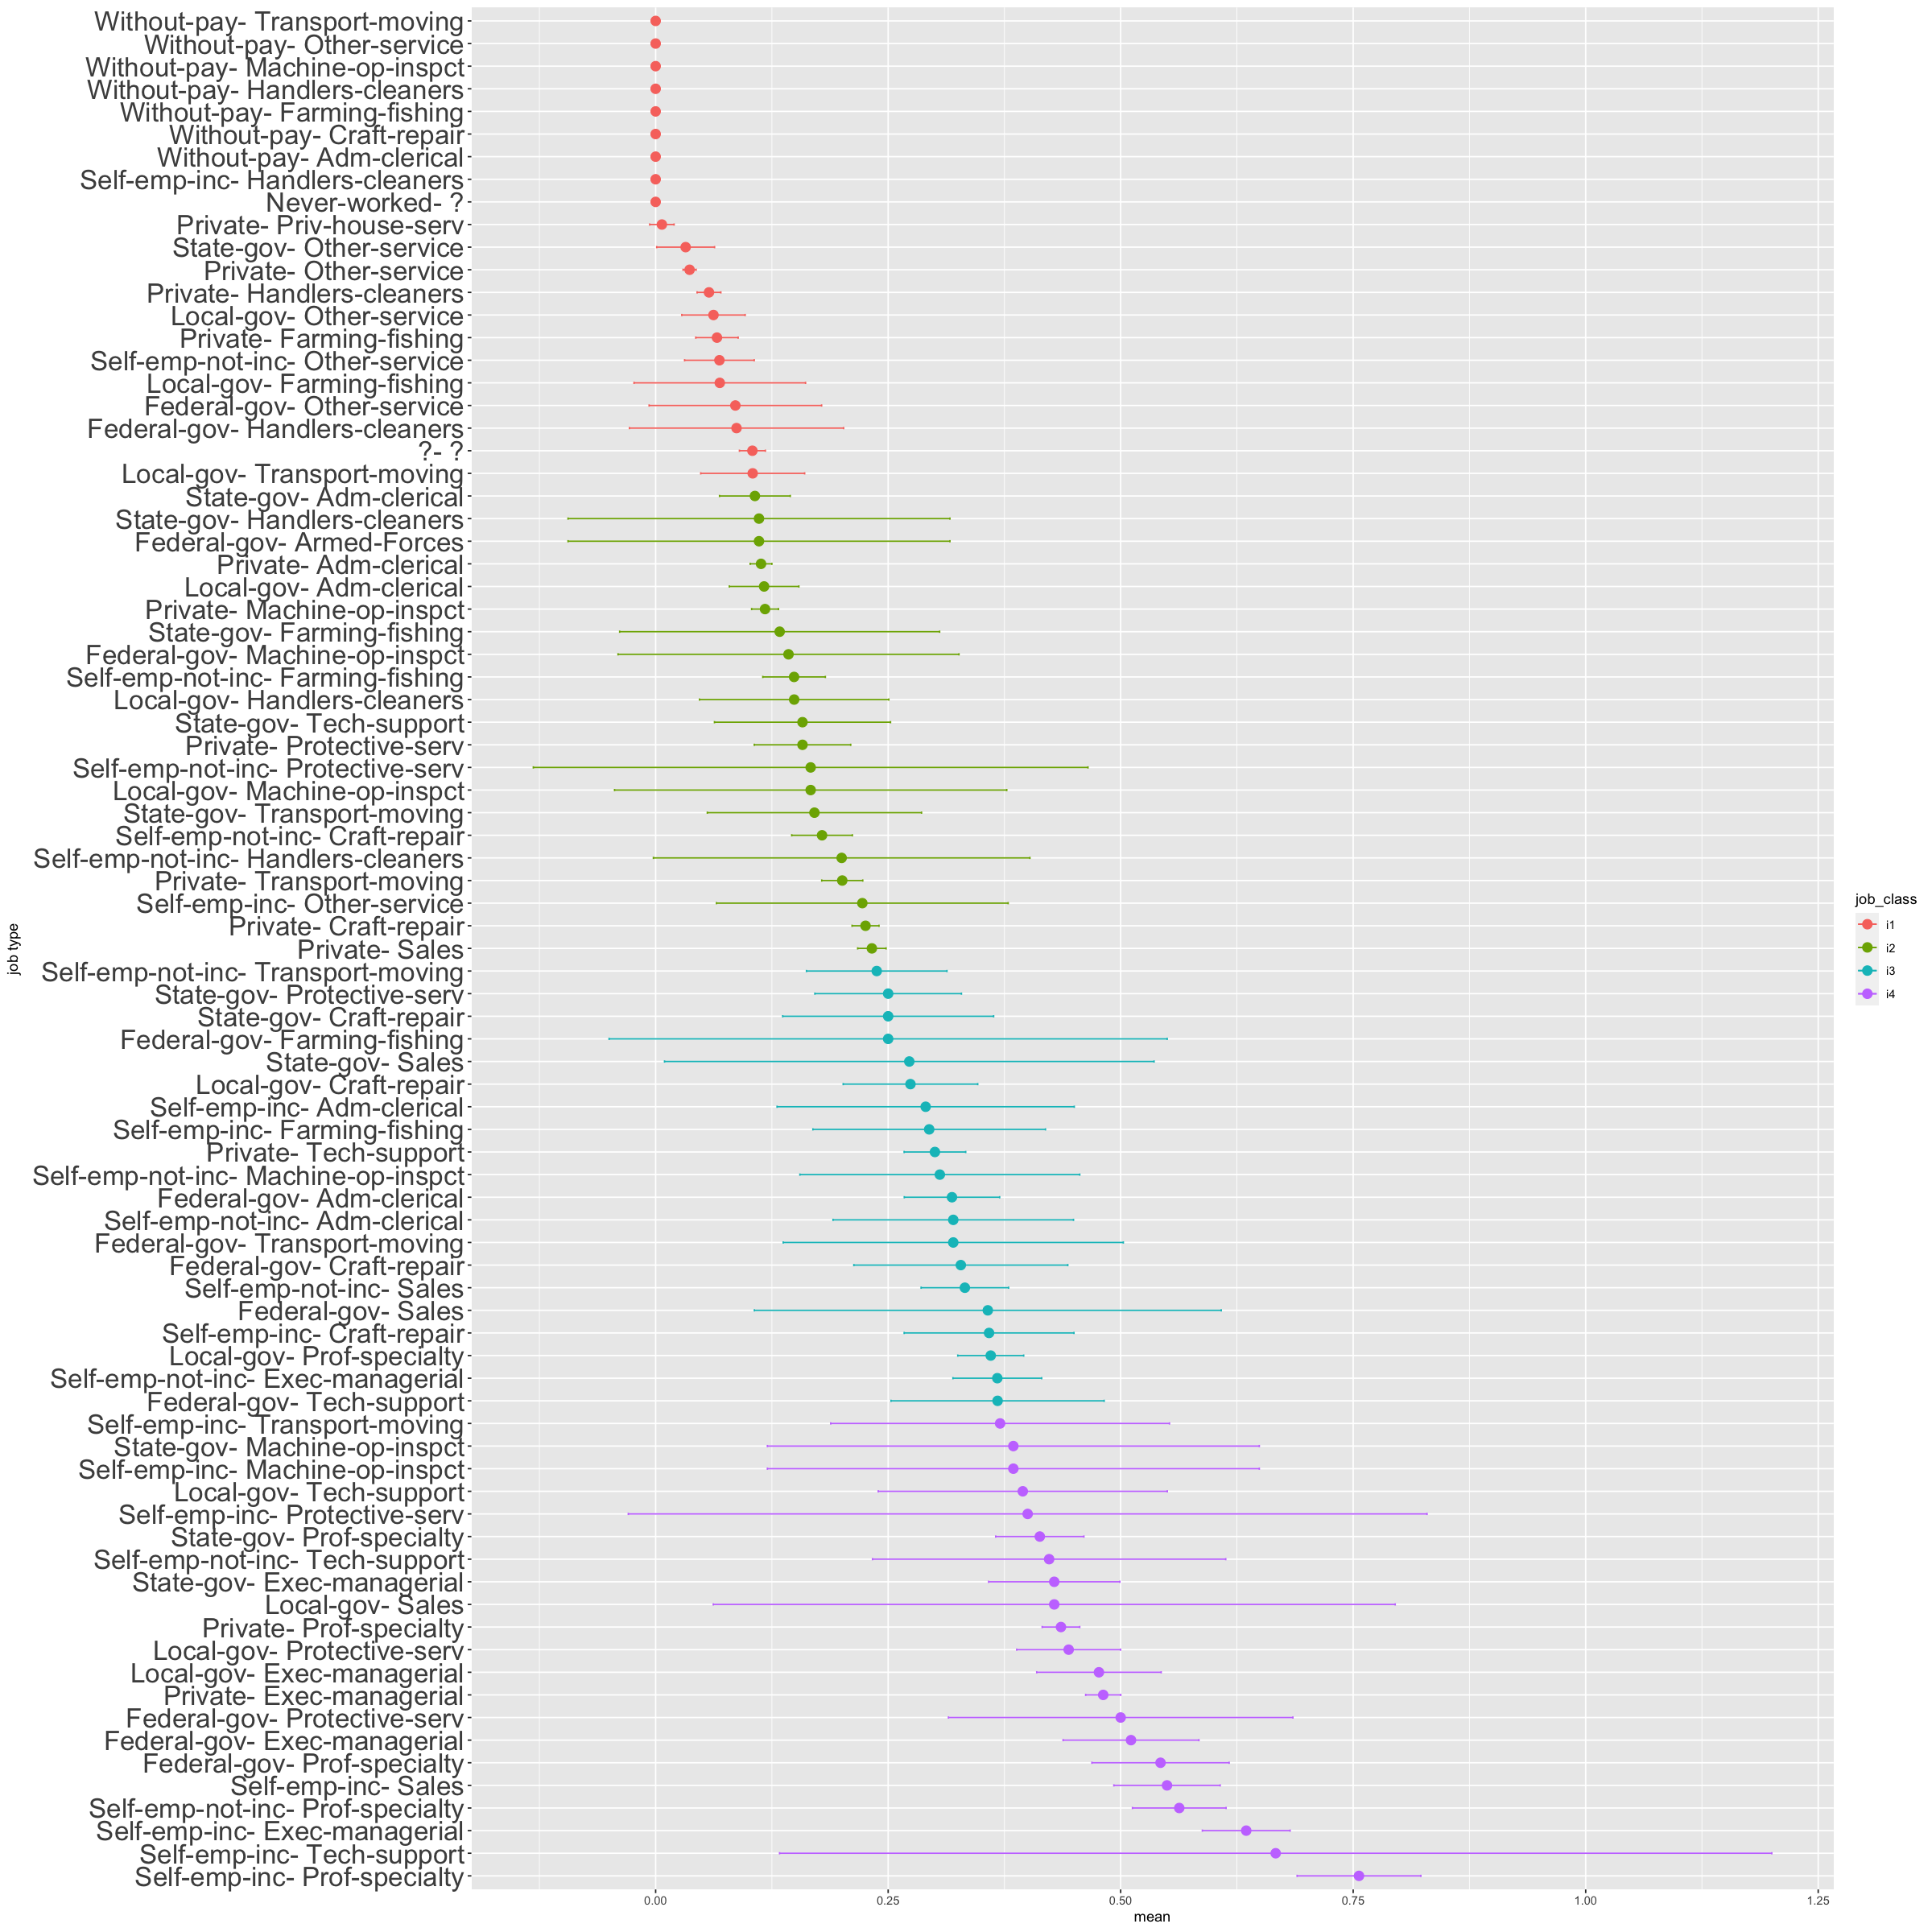

In [67]:
options(repr.plot.width=20, repr.plot.height=20)
tmp %>% ggplot( aes(y = reorder(class, -mean), 
           x = mean,
          color = job_class)) +
  geom_point(size = 3) +
  geom_line() +
  geom_errorbar(aes(xmin = mean - 1.96*sd, 
                    xmax = mean + 1.96*sd), 
                width = .1)+
 theme(axis.text.y = element_text(size = 20)) +
    ylab('job type')


The `workclass` and `occupation` variables are important to predict income in the logistic model because different jobs have different incomes. If we put the original `workclass` and `occupation` variables along with their interactions into the model, the parameters will only tell us which job is more likely to earn 50k and nothing more. By incorporating so many categories, this will make the model very complex. Thus we grouped combinations of `workclass` and `occupation` into four `job_class` levels based on mean probability to earn an annual income over 50k. The above plot shows the grouping results. Different colors represent different `job_class` levels. The levels pertain to their respective mean income. Confidence intervals are also plotted for each combination.

The next few wordcloud plots will show the characteristics of different job classes. The larger the word in the plots, the more frequently they show up in the dataset of that particular `job_class`. That is, the large words represent the most common `workclass` or `occupation` in one level of the grouped variable `job_class`.

These plots suggest that people of "private" workclass or "handlers-cleaners" occupation have the lowest chances to earn over 50k; people of "private" workclass, "adm-clerical" occupation, or "craft-repair" occupation have middle-to-low chances;  people of "self-emp-not-inc" workclass, "tech-support" occupation, "local-gov" occupation, or "prof-specialty" occupation have middle-to-high chances; and people of "private" workclass, "prof-specialty" occupation, or "exec-managerial" occupation have the highest chances to earn over 50k.

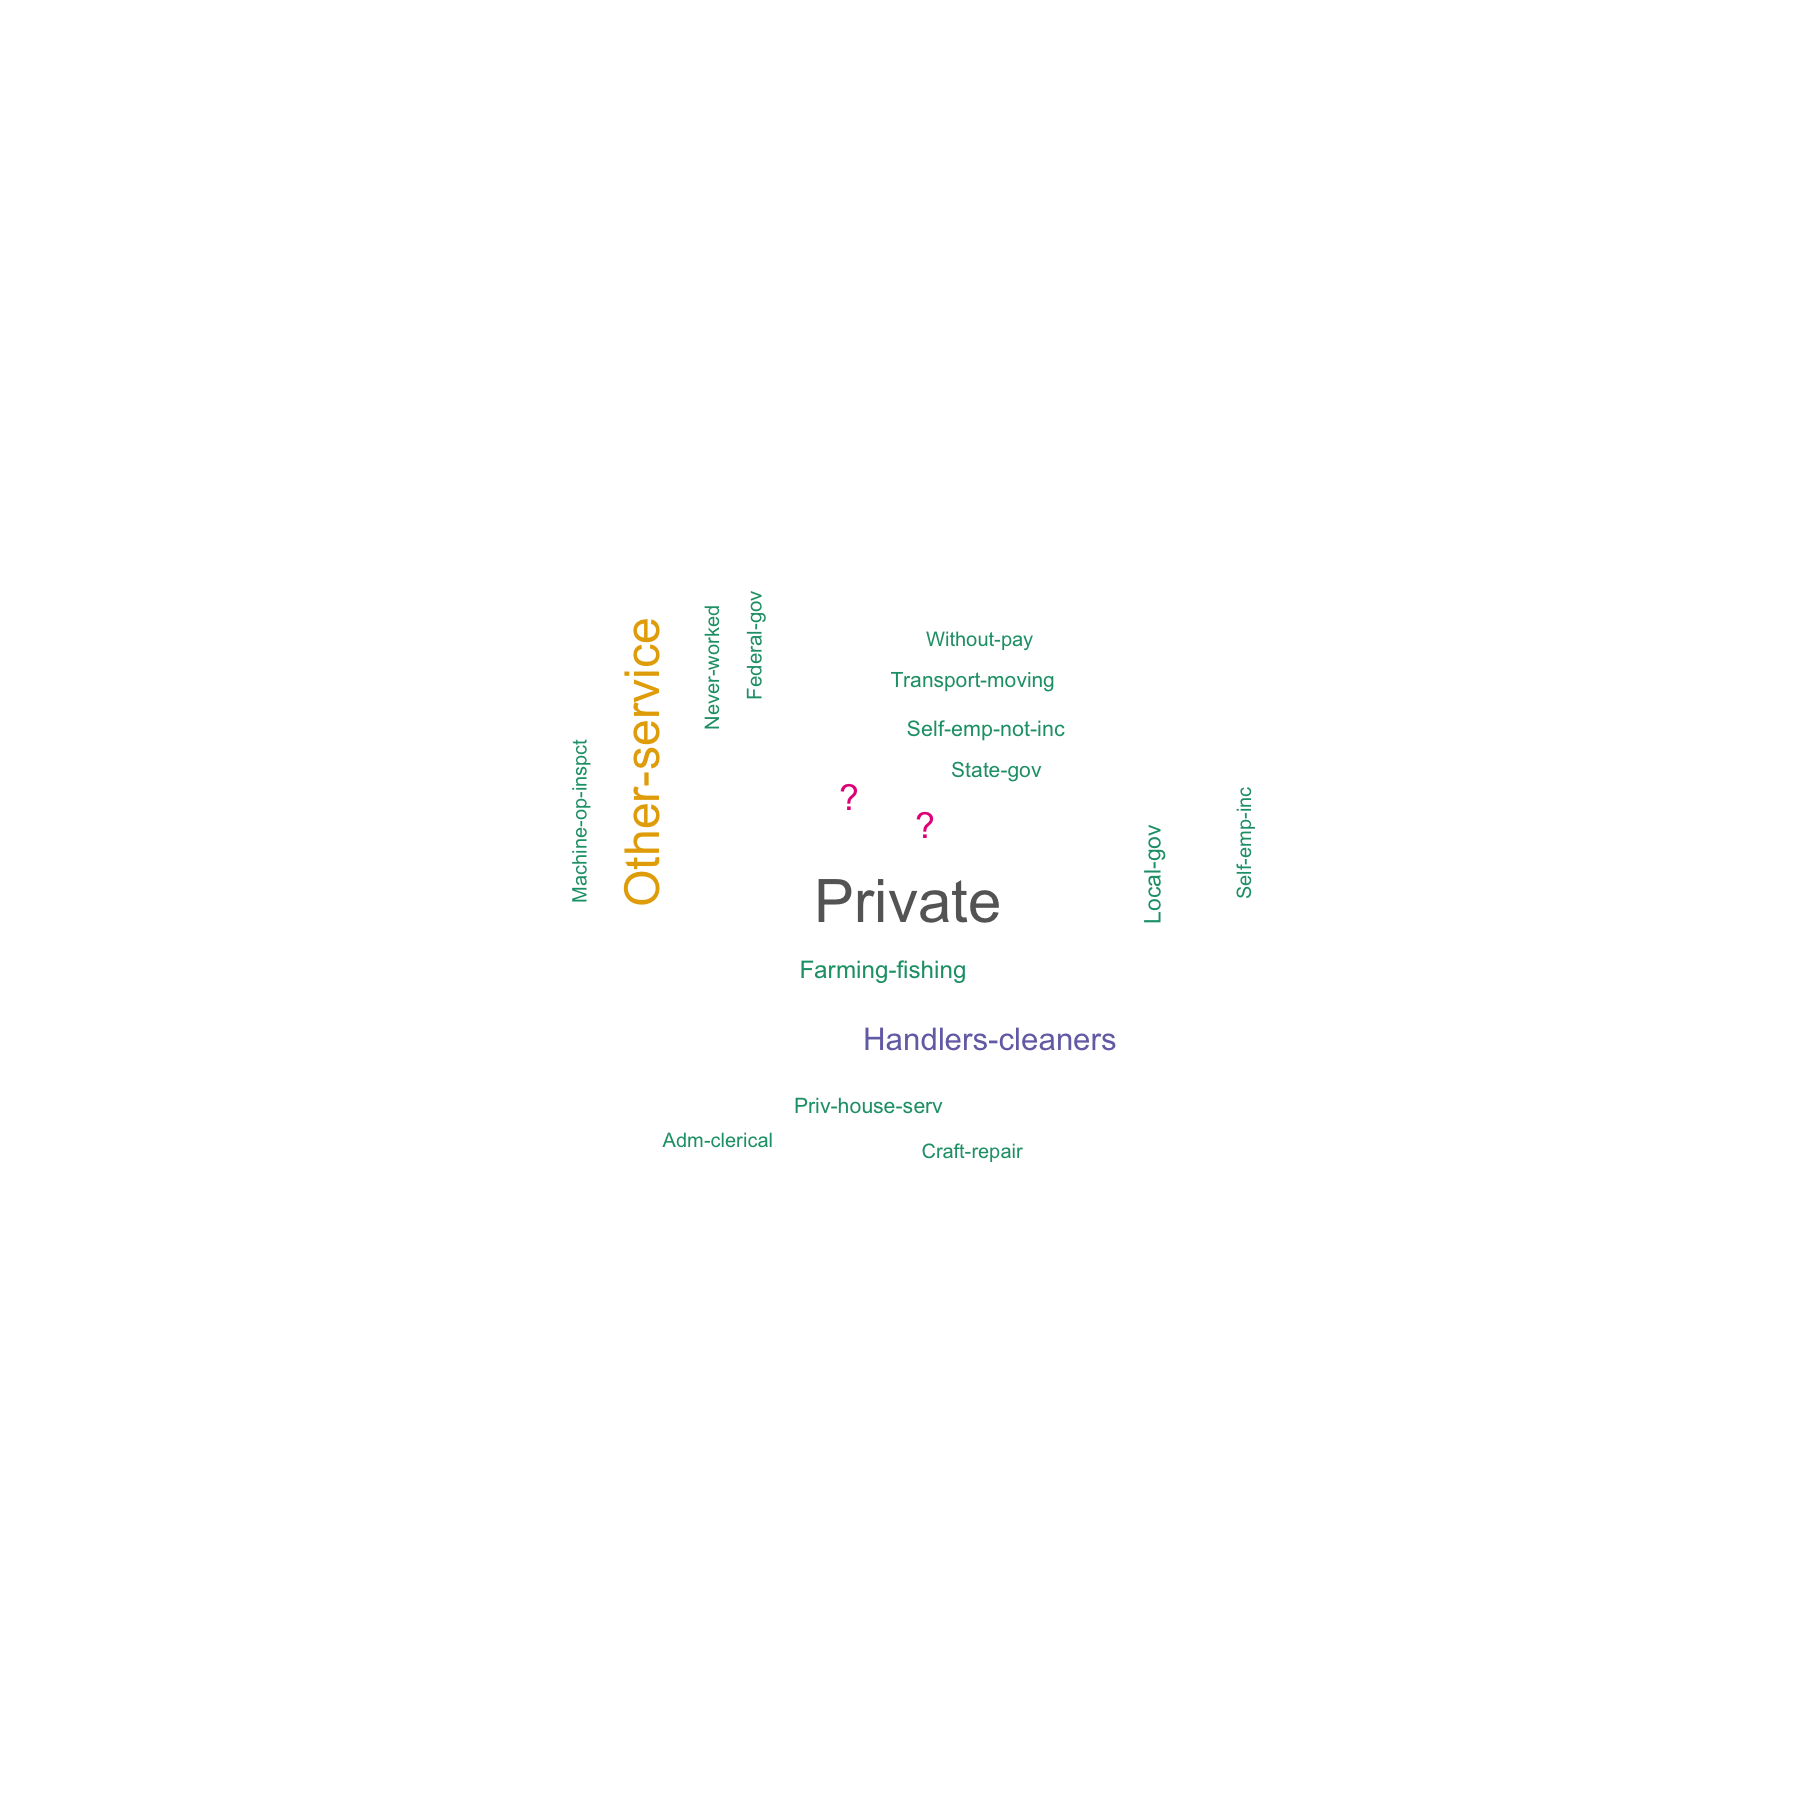

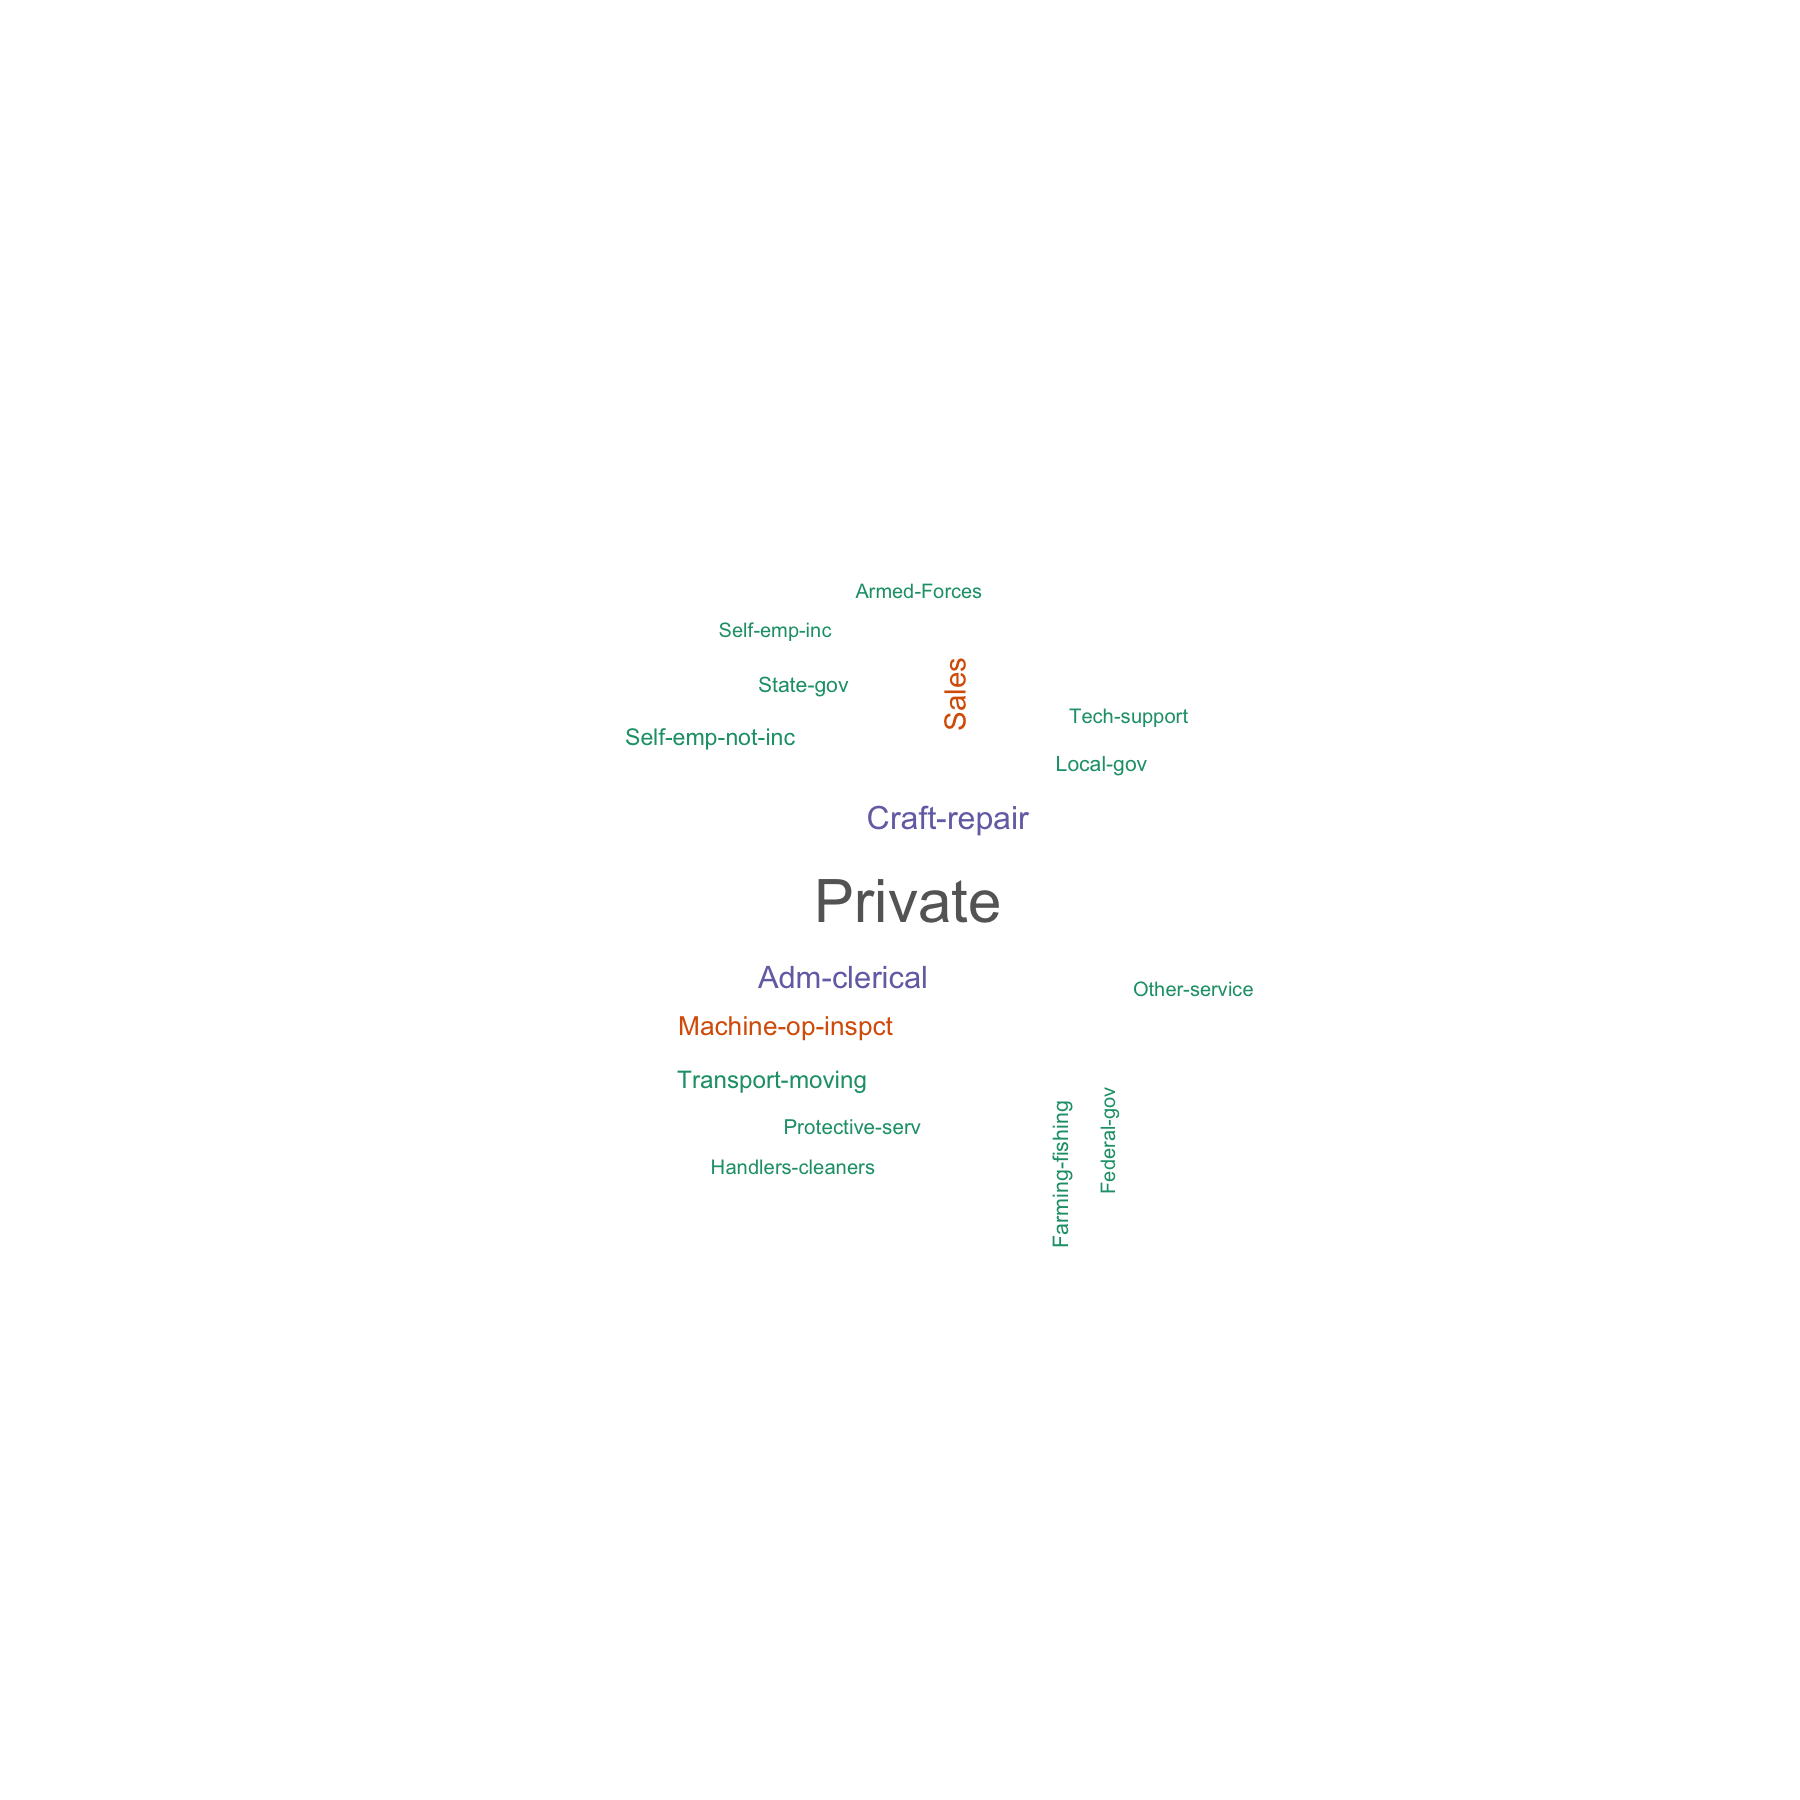

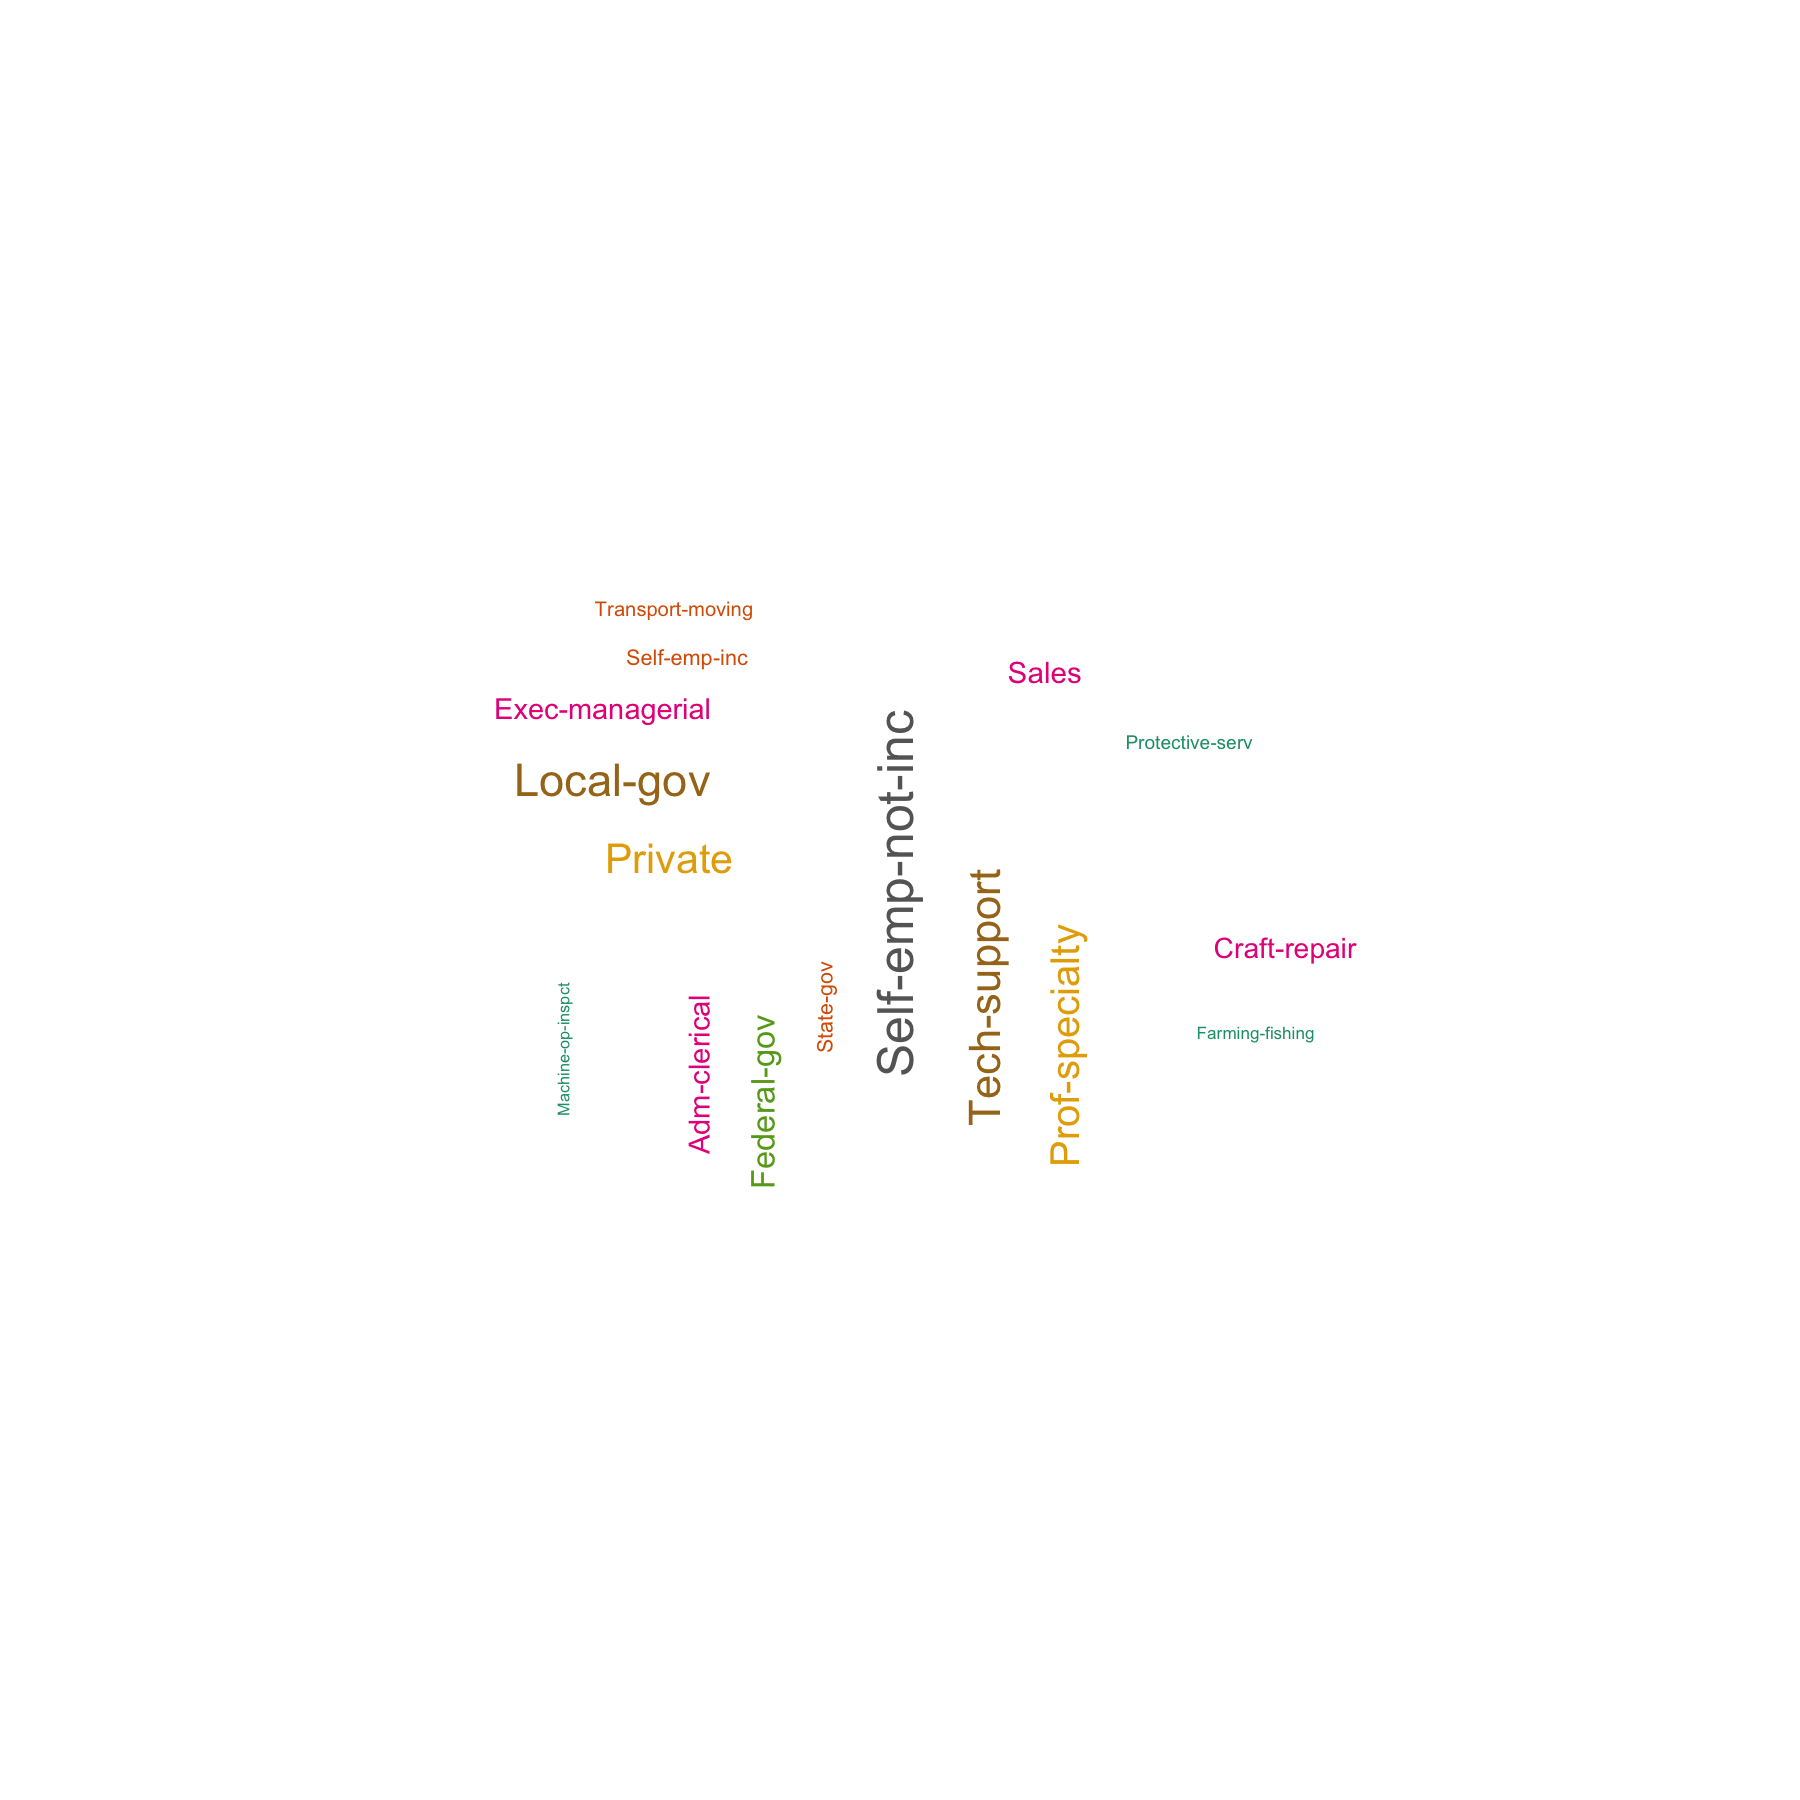

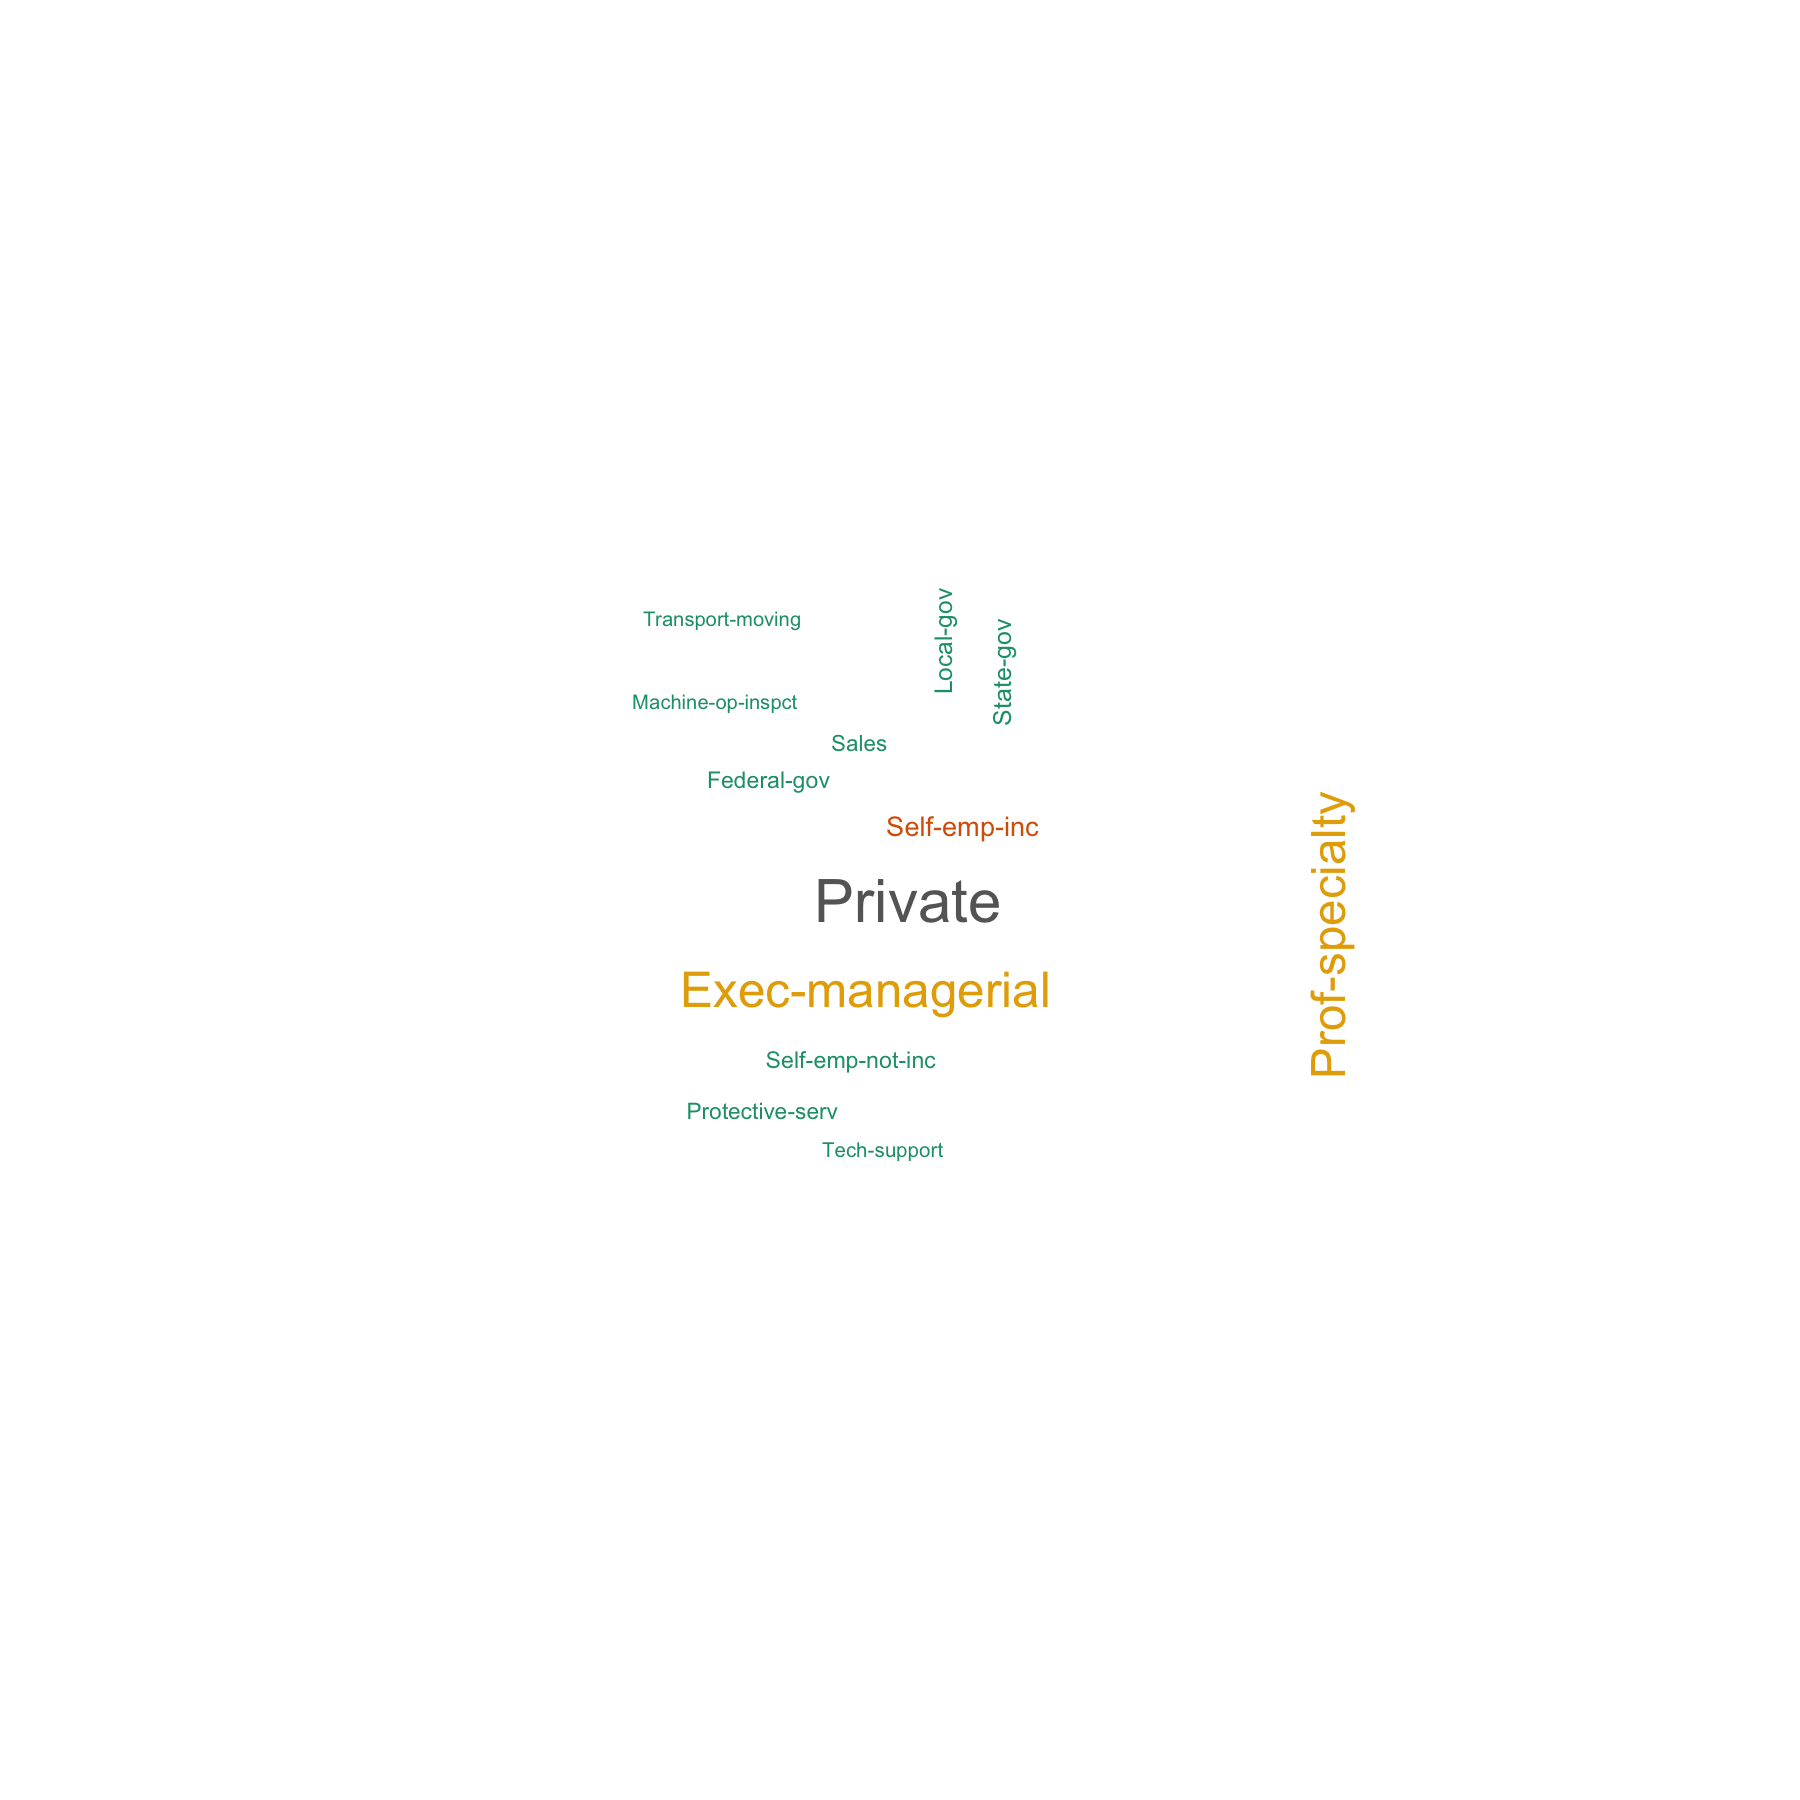

In [86]:
set.seed(2021)
options(repr.plot.width=15, repr.plot.height=15)
par(mar = rep(0, 4))
# split adult data by job_class
job_list <- adult_data$job_class %>% unique()
for (i in 1:length(job_list)) {
  new_df <- adult_data %>% filter(job_class == job_list[i])
  assign(paste0("new_df_", job_list[i]), new_df)

}

## word cloud 1
# get frequency of workclass
df_work_i1 <- new_df_i1 %>%
  group_by(workclass) %>% 
  summarise(count = n())
colnames(df_work_i1)[colnames(df_work_i1) == "workclass"] <- "job"

# get frequency of occupation
df_occ_i1 <- new_df_i1 %>% 
  group_by(occupation) %>% 
  summarise(count = n())
colnames(df_occ_i1)[colnames(df_occ_i1) == "occupation"] <- "job"

# combine dfs
wc_df_i1 <- rbind(df_work_i1, df_occ_i1)
wordcloud(words = wc_df_i1$job, freq = wc_df_i1$count, scale = c(3, 1), min.freq = 1,
          max.words=100, random.order=FALSE, rot.per=0.35, 
          colors=brewer.pal(8, "Dark2"),
         )


## word cloud 2
# get frequency of workclass
df_work_i2 <- new_df_i2 %>%
  group_by(workclass) %>% 
  summarise(count = n())
colnames(df_work_i2)[colnames(df_work_i2) == "workclass"] <- "job"

# get frequency of occupation
df_occ_i2 <- new_df_i2 %>% 
  group_by(occupation) %>% 
  summarise(count = n())
colnames(df_occ_i2)[colnames(df_occ_i2) == "occupation"] <- "job"

# combine dfs
wc_df_i2 <- rbind(df_work_i2, df_occ_i2)

wordcloud(words = wc_df_i2$job, freq = wc_df_i2$count, scale = c(3, 1), min.freq = 1,
          max.words=200, random.order=FALSE, rot.per=0.35, 
          colors=brewer.pal(8, "Dark2"))


## word cloud 3
# get frequency of workclass
df_work_i3 <- new_df_i3 %>%
  group_by(workclass) %>% 
  summarise(count = n())
colnames(df_work_i3)[colnames(df_work_i3) == "workclass"] <- "job"

# get frequency of occupation
df_occ_i3 <- new_df_i3 %>% 
  group_by(occupation) %>% 
  summarise(count = n())
colnames(df_occ_i3)[colnames(df_occ_i3) == "occupation"] <- "job"

# combine dfs
wc_df_i3 <- rbind(df_work_i3, df_occ_i3)

wordcloud(words = wc_df_i3$job, freq = wc_df_i3$count, scale = c(2.5, 0.75), min.freq = 1,
          max.words=200, random.order=FALSE, rot.per=0.35, 
          colors=brewer.pal(8, "Dark2"))

## word cloud 4
# get frequency of workclass
df_work_i4 <- new_df_i4 %>%
  group_by(workclass) %>% 
  summarise(count = n())
colnames(df_work_i4)[colnames(df_work_i4) == "workclass"] <- "job"

# get frequency of occupation
df_occ_i4 <- new_df_i4 %>% 
  group_by(occupation) %>% 
  summarise(count = n())
colnames(df_occ_i4)[colnames(df_occ_i4) == "occupation"] <- "job"

# combine dfs
wc_df_i4 <- rbind(df_work_i4, df_occ_i4)

wordcloud(words = wc_df_i4$job, freq = wc_df_i4$count, scale = c(3, 1), min.freq = 1,
          max.words=200, random.order=FALSE, rot.per=0.35, 
          colors=brewer.pal(8, "Dark2"))


### Logistic Regression


#### Model Description
Since the response (income) is a binary variable which indicates whether or not a person's annual income exceeds 50,000 dollars, logistic regression is suitable for this dataset. Therefore, we employ a standard logistic regression model to capture the relationship between income and other variables of interest. In mathematical form, logistic regression uses a linear combination of other variables to model the log-odds-ratio:
$$log(\frac{p_i}{1-p_i}) = X_i\beta,$$
where $p_i = Pr(Y_i = 1)$ is the probability of sample $i$'s income exceeding 50k, and $X_i$ are the independent variables for sample $i$. The term $\frac{p_i}{1-p_i}$ is called the **odds ratio** and will be used to explain the results.

#### Model Selection
Because there are many variables in our final dataset, we also used model selection methods to eliminate irrelevant or redundant variables. More specifically, we tried stepwise regression (using AIC and BIC criteria) and ElasticNet to perform model selection. 
In this specific dataset, we found that ElasticNet is no better than stepwise regression in terms of prediction accuracy in the test set. In addition, ElasticNet could not give us significance levels of the estimated parameters. Thus, we will only report and discuss results from the AIC/BIC method and leave the ElasticNet results in the Appendix. 


For AIC and BIC methods, we used the `stepAIC` function in package `MASS` for implementation. We used the bidirectional elimination (`direction = 'both'`) option with a full model as the initial model. The following table shows the estimated parameters and related p-values from AIC and BIC methods. 

In [22]:
lr_baseline = glm(data = train_data,
                formula = income ~ .,
                family = 'binomial')
AIC_model = suppressWarnings(MASS::stepAIC(lr_baseline, direction = 'both', trace = F))
BIC_model = suppressWarnings(MASS::stepAIC(lr_baseline, direction = 'both',
                          k = log(nrow(train_data)),
                          trace = F))

aic_res = tidy(AIC_model) %>% select(-std.error,-statistic)
bic_res = tidy(BIC_model) %>% select(-std.error,-statistic)
names(aic_res) <- c('term','AIC_Estimation','AIC.p.value')
names(bic_res) <- c('term','BIC_Estimation','BIC.p.value') 
model_summary = full_join(aic_res, bic_res, by = 'term')
model_summary$AIC.p.value = round(model_summary$AIC.p.value,2)
model_summary$BIC.p.value = round(model_summary$BIC.p.value,2)
model_summary

predicted_prob = predict(AIC_model, test_data %>% select(-income), type = 'response' )
predicted_y = predicted_prob
threshold = 0.5
predicted_y[predicted_prob>threshold] = 1
predicted_y[predicted_prob<=threshold] = 0
print(paste("The prediction accuracy of the full logistic regression is:", round(mean(predicted_y==test_data$income), 4)))    


predicted_prob = predict(AIC_model, test_data %>% select(-income), type = 'response' )
predicted_y = predicted_prob
threshold = 0.5
predicted_y[predicted_prob>threshold] = 1
predicted_y[predicted_prob<=threshold] = 0
print(paste("The prediction accuracy of model selected by AIC is:", round(mean(predicted_y==test_data$income), 4)))    


predicted_prob = predict(BIC_model, test_data %>% select(-income), type = 'response' )
predicted_y = predicted_prob
threshold = 0.5
predicted_y[predicted_prob>threshold] = 1
predicted_y[predicted_prob<=threshold] = 0
print(paste("The prediction accuracy of model selected by BIC is:", round(mean(predicted_y==test_data$income), 4)))    

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


term,AIC_Estimation,AIC.p.value,BIC_Estimation,BIC.p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-7.358213e+00,0.00,-7.387514e+00,0
age,2.408237e-02,0.00,2.428801e-02,0
fnlwgt,7.929900e-07,0.00,7.577507e-07,0
education_num,2.785793e-01,0.00,2.808253e-01,0
marital_status Never-married,-2.620218e+00,0.00,-2.623701e+00,0
marital_status Divorced,-2.078300e+00,0.00,-2.083739e+00,0
marital_status Separated,-2.223610e+00,0.00,-2.246774e+00,0
marital_status Widowed,-2.084231e+00,0.00,-2.088726e+00,0
race Black,-1.621710e-01,0.03,NA,NA


[1] "The prediction accuracy of the full logistic regression is: 0.8482"
[1] "The prediction accuracy of model selected by AIC is: 0.8482"
[1] "The prediction accuracy of model selected by BIC is: 0.8484"


Compared with the original model, AIC only drops the GDP per capita variable of the native country. BIC drops one more variable in addition to that, which is race. Almost all the remaining variables are significant in both methods. The model selected by AIC has a similar test accuracy compared to the full model, while the model selected by BIC has a slightly better test accuracy. 

Noticing that the level `Asian-Pac-Islander` in race is not significant, we apply a likelihood ratio test to see if the variable `race` is significant as a whole. To achieve this, we use the `anova` function to test between the model selected by AIC (`AIC_model`) and the model selected by BIC `BIC_model`, since `BIC_model` is a nested model of  `AIC_model` by losing race as a predictor.

In [35]:
anova(AIC_model,BIC_model, test = 'Chisq')

,Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,32541,21282.19,NA,NA,NA
2,32545,21302.20,-4,-20.00904,0.0004973514


As we can see from the results of the above likelihood ratio test, the p-value is very small. Thus, the variable `race` is significant overall. In addition, when removing race from the model, the improved prediction accuracy is negligible. Thus, based on the above reasons, we decided to use the model selected by AIC as our final model for inference and discussion.

#### Goodness of Fit

In this subsection, we will briefly discuss the goodness of fit of the final model selected by AIC criteria. First of all, as we can see from the summary table of the AIC estimations, almost all variables are significant except the `Asian-Pac-Islander` level of `race`. From the likelihood ratio test for `race`, we conclude that `race` is significant in the model. Therefore, all variables are significantly related to level of income and can be used for inference. Second, compared with the intercept-only model, our model is very significant (the p-values from the likelihood ratio test are almost 0, see the codes and results below). Finally, the prediction accuracy of our model on the test set is 0.8482. Compared with just predicting the most possible outcome, it has 0.1 higher prediction accuracy. The p-value of  Mcnemar's Test (a test with H0 being predicted income level is unrelated to the actual income level) is close to zero. Thus, the logistic regression model chosen by AIC indeed learned much information from the data. 

In [40]:
anova(AIC_model, glm(formula = income ~ 1, data=train_data, family = 'binomial'), test = 'Chisq')

predicted_prob = predict(AIC_model, test_data %>% select(-income), type = 'response' )
predicted_y = predicted_prob
threshold = 0.5
predicted_y[predicted_prob>threshold] = 1
predicted_y[predicted_prob<=threshold] = 0
confusionMatrix(as.factor(predicted_y), as.factor(test_data$income), 
                positive = NULL,
                dnn = c("Prediction", "Reference"))


,Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,32541,21282.19,NA,NA,NA
2,32560,35948.08,-19,-14665.89,0


Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 11556  1605
         1   863  2238
                                          
               Accuracy : 0.8482          
                 95% CI : (0.8426, 0.8537)
    No Information Rate : 0.7637          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.5495          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.9305          
            Specificity : 0.5824          
         Pos Pred Value : 0.8780          
         Neg Pred Value : 0.7217          
             Prevalence : 0.7637          
         Detection Rate : 0.7106          
   Detection Prevalence : 0.8093          
      Balanced Accuracy : 0.7564          
                                          
       'Positive' Class : 0               
                  

#### Model Interpretation

In this subsection, we will discuss what the estimated coefficients mean under the context of our research questions. 

First,the variables age, number of years of education, working hours per week are positively related to the income level, which makes sense intuitively. Second, for the `job_class` variable we grouped, the coefficients are consistent with the classes. Compared with the lowest income group, the middle-low income group is more likely to have an annual income exceeding 50k. The probability of this increases more for the middle-high and high income groups. Third, the positive coefficient of the weights `Fnlwgt` suggests that the more people this sample can represent, the higher the chance of income exceeding 50k. Forth, either capital gain or capital loss is positively related to income level. Surprisingly, the coefficient for capital loss is bigger than that of capital gain. One possible explanation may be that people with high incomes tend to invest in capital assets and people with higher incomes tend to choose more risky assets to invest in. Therefore, higher capital loss might indicate that a person may have a high enough income to tolerate the risk of capital investment. Fifth, compared with white people, other races are less likely to earn over 50k except for `Asia-Pac-IsIander`, but this level is not significant. Sixth, compared with females, males have a higher chance to earn over 50k. Finally, compared with married people, people of other marital status are less likely to earn over 50k. The `never-married` has the smallest coefficients, which suggests that compared with others, people that never marry have the lowest chance to earn over 50k. This is because most unmarried people are young, and are unlikely to earn 50k at the start of their careers.


## Discussion

In this section, we will conclude this report with a discussion of our findings, limitations, and some directions for future works.

### Conclusions

In this report, we have investigated the adult dataset with a logistic regression model. The fitted model can predict whether a person's income exceeds 50,000 USD with an 85% accuracy on the test set. The model parameters suggest different race groups and gender groups have different chances to earn a high income (over 50k). These findings suggest that there may be some unfairness in salary systems for different people groups. More studies are needed to investigate if female or minority race groups are unfairly treated by companies, and more research is needed to determine solutions to mitigate this unfairness.


### Limitations &  Furture Directions

This is an observational study based on a census dataset. Thus, the only conclusions we can draw are associations, not causations. Since it is impossible to control some variables such as one's gender or race to create a random control experiment, causal conclusions are difficult to draw for the likelihood of unfairness existing. However, some studies can help investigate income unfairness. For example, we can create a study that allows the human resources department of companies to decide one's payment package just based on a detailed CV and can manipulate the gender and race information there. 

The dataset only records whether or not one's income exceeds 50k. Much information is lost in this binary variable because we don't know the overall continuous distribution of incomes. A similar study can be done with continuous income data and the results of that will be more informative. Furthermore, a more advanced and interpretable machine learning method could better capture the complex relationships between income and predictor variables.


## Citations

[1] Kohavi, Ron. "Scaling Up the Accuracy of Naive-Bayes Classifiers: a." Proceedings of the Second International Conference on. 1996.

[2] Chakrabarty, Navoneel, and Sanket Biswas. "A statistical approach to adult census income level prediction." 2018 International Conference on Advances in Computing, Communication Control and Networking (ICACCCN). IEEE, 2018.

[3] Zemel, Rich, et al. "Learning fair representations." International conference on machine learning. PMLR, 2013.

[4] Ding F, Hardt M, Miller J, et al. Retiring Adult: New Datasets for Fair Machine Learning[C]//Thirty-Fifth Conference on Neural Information Processing Systems. 2021.

[5] https://archive.ics.uci.edu/ml/datasets/Adult

[6] https://data.worldbank.org/indicator/NY.GDP.PCAP.CD?name_desc=false

[7] https://data.worldbank.org/indicator/NY.ADJ.NNTY.PC.CD


## Appendix

### Variable selection via ElasticNet

We tried an ElasticNet model with cross validation to tune the hyper-parameters. We found that this method was not able to improve prediction accuracy. And it was not easy to deal with categorical variables and parameter significance. Therefore, we decided to use the classic AIC/BIC method to perform model selection.

In [39]:
for(alpha in (0:10)/10){
    x_train <- model.matrix( ~ .-1 , train_data%>%select(-income))
    lm = cv.glmnet(x=x_train,y = as.factor(train_data$income), 
                   intercept=TRUE ,
                   family =   "binomial", 
                   nfolds=5,
                  alpha = alpha)
    best_lambda <- lm$lambda[which.min(lm$cvm)]
    predicted_prob_lm = predict(lm, model.matrix( ~ .-1, test_data%>%select(-income)), type = 'response')
    predicted_y = predicted_prob_lm
    threshold = 0.5
    predicted_y[predicted_prob_lm>threshold] = 1
    predicted_y[predicted_prob_lm<=threshold] = 0
    cat(mean(predicted_y==test_data$income))
    cat('\n')
}

0.840856
0.8458369
0.8466978
0.8470668
0.8463904
0.8469438
0.8471898
0.8474357
0.8474357
0.8476202
0.8476202
